In [1]:
import nltk
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import Counter
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')




In [2]:
path = '../Data_articles'
data_dirs = [x for x in os.listdir(path) if not x.startswith(".")]


In [3]:
articles = [json.load(open(os.path.join(path,data,d))) for data in data_dirs for d in os.listdir(os.path.join(path,data)) if d.endswith('.json')]


In [5]:

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

resources = ['punkt', 'stopwords', 'vader_lexicon', 'wordnet', 'averaged_perceptron_tagger','punkt_tab']

print("Descargando recursos de NLTK...")
for resource in resources:
    try:
        result = nltk.download(resource, quiet=True)
        if result:
            print(f"✅ {resource} - OK")
        else:
            print(f"ℹ️  {resource} - Ya existe")
    except Exception as e:
        print(f"❌ {resource} - Error: {e}")

print("Configuración de NLTK completada")


Descargando recursos de NLTK...
✅ punkt - OK
✅ stopwords - OK
✅ vader_lexicon - OK
✅ wordnet - OK
✅ averaged_perceptron_tagger - OK
✅ punkt_tab - OK
Configuración de NLTK completada


In [6]:
nltk.download("cess_esp")
nltk.download('conll2002')
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package cess_esp to
[nltk_data]     /Users/alberto/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!
[nltk_data] Downloading package conll2002 to
[nltk_data]     /Users/alberto/nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /Users/alberto/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/alberto/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [7]:
from nltk.corpus import cess_esp,treebank
treebank.tagged_sents()

[[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')], [('Mr.', 'NNP'), ('Vinken', 'NNP'), ('is', 'VBZ'), ('chairman', 'NN'), ('of', 'IN'), ('Elsevier', 'NNP'), ('N.V.', 'NNP'), (',', ','), ('the', 'DT'), ('Dutch', 'NNP'), ('publishing', 'VBG'), ('group', 'NN'), ('.', '.')], ...]

In [5]:

stop_words_es = stopwords.words('spanish')
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

In [9]:

print(f"Total de artículos: {len(articles)}")


Total de artículos: 18254


In [13]:
def clean_text(text):
    """
    Limpia y preprocessa el texto
    """
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    
    #text = re.sub(r'[^\w\s]', ' ', text)
    #text = re.sub(r'\d+', '', text)
    
    text = ' '.join(text.split())
    
    return text

def extract_text_from_articles(articles):
    """
    Extrae el texto de los artículos dependiendo de su estructura
    """
    texts = []
    for article in articles:
        if isinstance(article, dict):
            text_content = ""
            if 'text' in article:
                text_content = article['text']
            
            if text_content:
                texts.append(clean_text(text_content))
        elif isinstance(article, str):
            texts.append(clean_text(article))
    
    return [text for text in texts] 

clean_texts = extract_text_from_articles(articles)
print(f"Textos procesados: {len(clean_texts)}")


Textos procesados: 18250


## Análisis Básico de Texto

In [11]:

def basic_text_stats(texts):
    """
    Calcula estadísticas básicas de una colección de textos
    """
    all_text = ' '.join(texts)
    
    words = word_tokenize(all_text, language='spanish')
    sentences = sent_tokenize(all_text, language='spanish')
    
    words_no_stop = [word for word in words if word.lower() not in stop_words_es and len(word) > 2]
    
    stats = {
        'total_textos': len(texts),
        'total_caracteres': len(all_text),
        'total_palabras': len(words),
        'palabras_unicas': len(set(words)),
        'total_oraciones': len(sentences),
        'palabras_sin_stopwords': len(words_no_stop),
        'palabras_unicas_sin_stopwords': len(set(words_no_stop)),
        'promedio_palabras_por_texto': len(words) / len(texts) if texts else 0,
        'promedio_oraciones_por_texto': len(sentences) / len(texts) if texts else 0
    }
    
    return stats, words_no_stop

if clean_texts:
    stats, words_filtered = basic_text_stats(clean_texts)
    
    for key, value in stats.items():
        if isinstance(value, float):
            print(f"{key.replace('_', ' ').title()}: {value:.2f}")
        else:
            print(f"{key.replace('_', ' ').title()}: {value:,}")
else:
    print("No hay textos para analizar")

Total Textos: 18,250
Total Caracteres: 43,598,968
Total Palabras: 7,782,878
Palabras Unicas: 115,478
Total Oraciones: 224,595
Palabras Sin Stopwords: 3,685,645
Palabras Unicas Sin Stopwords: 114,507
Promedio Palabras Por Texto: 426.46
Promedio Oraciones Por Texto: 12.31


## Análisis de Frecuencia de Palabras

TOP 20 PALABRAS MÁS FRECUENTES:
presidente : 15837 veces
país : 15347 veces
gobierno : 14811 veces
venezuela : 12010 veces
nacional : 12001 veces
parte : 11920 veces
unidos : 9659 veces
personas : 9189 veces
gaza : 9015 veces
pueblo : 9011 veces
según : 8806 veces
acuerdo : 8224 veces
israel : 8178 veces
internacional : 7702 veces
países : 7632 veces
además : 7573 veces
seguridad : 7246 veces
años : 7242 veces
mientras : 7151 veces
tras : 6989 veces


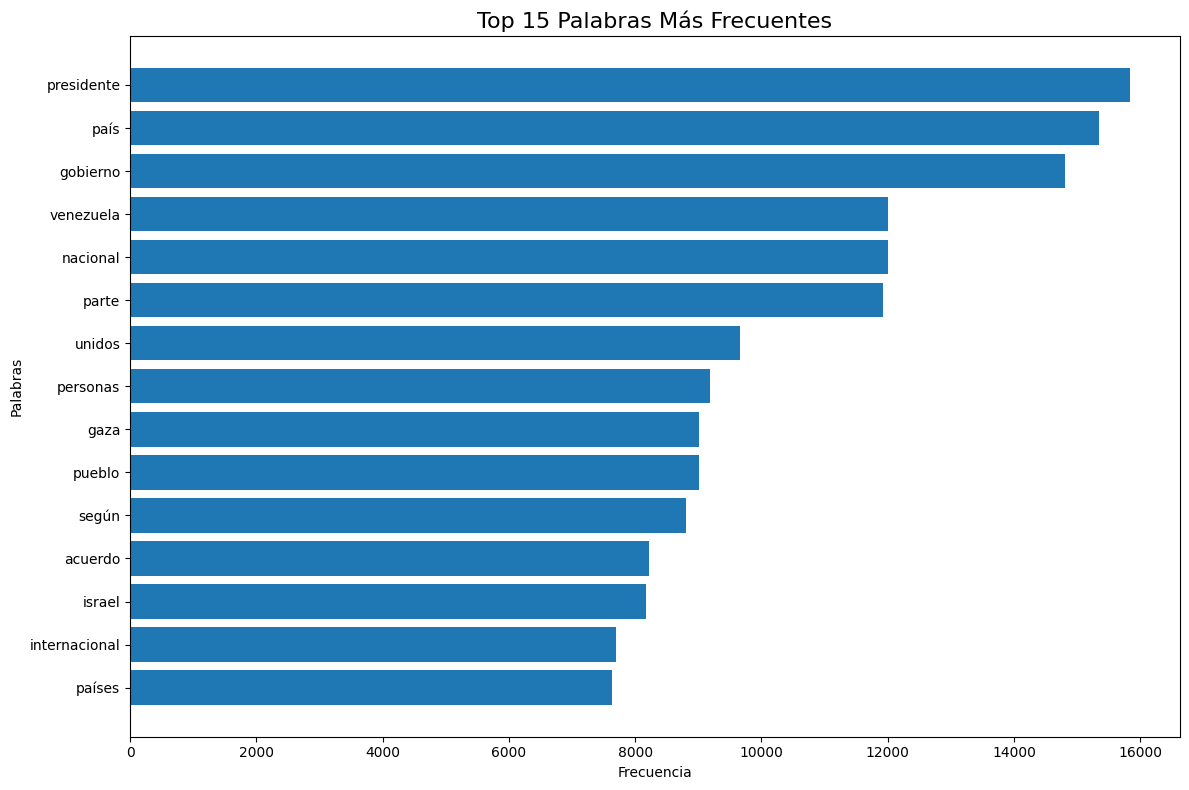


Vocabulario: 114507 palabras únicas


In [12]:

if clean_texts and 'words_filtered' in locals():
    word_freq = Counter(words_filtered)
    
    print("TOP 20 PALABRAS MÁS FRECUENTES:")
    for word, freq in word_freq.most_common(20):
        print(f"{word} : {freq} veces")
    
    top_words = dict(word_freq.most_common(15))
    
    plt.figure(figsize=(12, 8))
    plt.barh(list(top_words.keys())[::-1], list(top_words.values())[::-1])
    plt.title('Top 15 Palabras Más Frecuentes', fontsize=16)
    plt.xlabel('Frecuencia')
    plt.ylabel('Palabras')
    plt.tight_layout()
    plt.show()
    
    print(f"\nVocabulario: {len(word_freq)} palabras únicas")

## Análisis de Sentimientos

In [13]:

def analyze_sentiment(texts):
    """
    Analiza el sentimiento de una colección de textos usando VADER
    """
    sentiments = []
    
    for i, text in enumerate(texts):
        
            scores = sia.polarity_scores(text)
            
            if scores['compound'] >= 0.05:
                sentiment = 'Positivo'
            elif scores['compound'] <= -0.05:
                sentiment = 'Negativo'
            else:
                sentiment = 'Neutral'
            
            sentiments.append({
                'texto_id': i,
                'sentimiento': sentiment,
                'compound': scores['compound'],
                'positive': scores['pos'],
                'neutral': scores['neu'],
                'negative': scores['neg']
            })
    
    return sentiments

if clean_texts:
    sentiment_results = analyze_sentiment(clean_texts)
    
    sentiment_counts = Counter([s['sentimiento'] for s in sentiment_results])
    
    print("ANÁLISIS DE SENTIMIENTOS:")
    for sentiment, count in sentiment_counts.items():
        percentage = (count / len(sentiment_results)) * 100
        print(f"{sentiment:<10}: {count:>3} textos ({percentage:.1f}%)")
    
    compound_scores = [s['compound'] for s in sentiment_results]
    print(f"\nESTADÍSTICAS DE COMPOUND SCORE:")
    print(f"Promedio: {np.mean(compound_scores):.3f}")
    print(f"Mediana: {np.median(compound_scores):.3f}")
    print(f"Desviación estándar: {np.std(compound_scores):.3f}")
    print(f"Mínimo: {np.min(compound_scores):.3f}")
    print(f"Máximo: {np.max(compound_scores):.3f}")

ANÁLISIS DE SENTIMIENTOS:
Positivo  : 5909 textos (32.4%)
Negativo  : 10275 textos (56.3%)
Neutral   : 2066 textos (11.3%)

ESTADÍSTICAS DE COMPOUND SCORE:
Promedio: -0.191
Mediana: -0.273
Desviación estándar: 0.545
Mínimo: -0.998
Máximo: 0.995


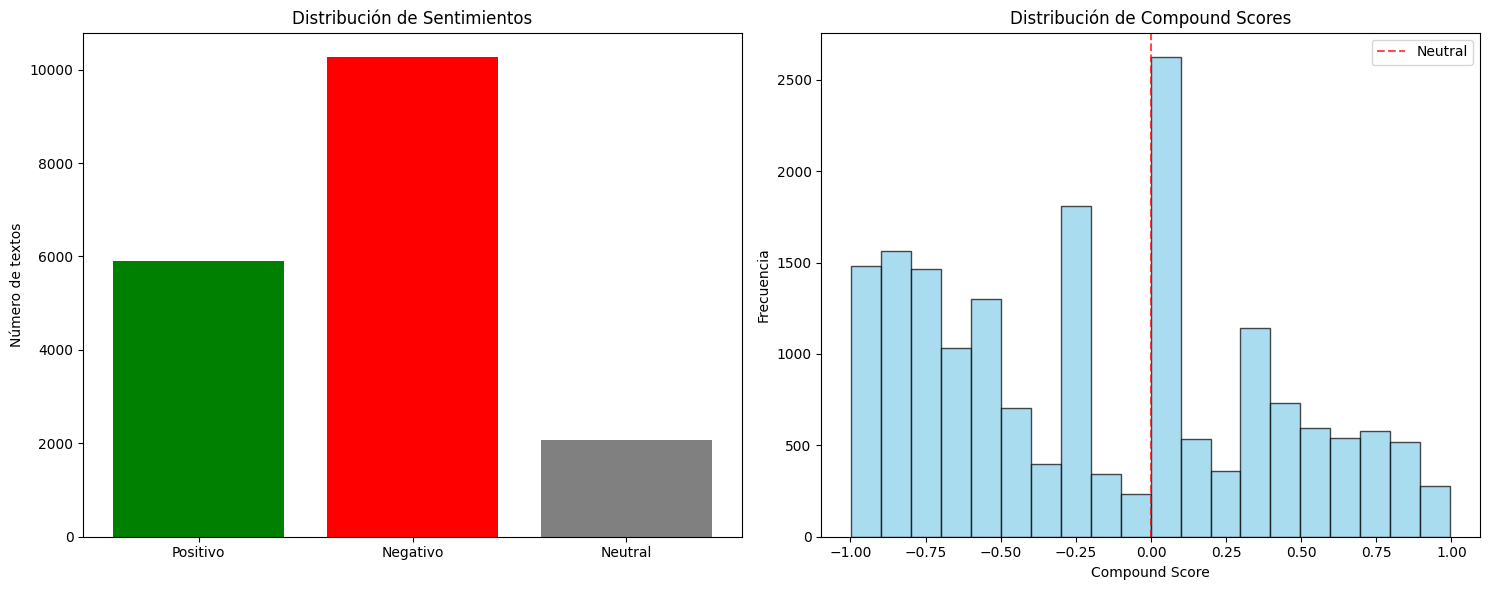

In [14]:

if clean_texts and 'sentiment_results' in locals():

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    sentiments = list(sentiment_counts.keys())
    counts = list(sentiment_counts.values())
    colors = ['green' if s == 'Positivo' else 'red' if s == 'Negativo' else 'gray' for s in sentiments]
    
    ax1.bar(sentiments, counts, color=colors)
    ax1.set_title('Distribución de Sentimientos')
    ax1.set_ylabel('Número de textos')
    
    ax2.hist([s['compound'] for s in sentiment_results], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_title('Distribución de Compound Scores')
    ax2.set_xlabel('Compound Score')
    ax2.set_ylabel('Frecuencia')
    ax2.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

## Análisis de N-gramas

ANÁLISIS DE N-GRAMAS:

TOP 10 BIGRAMAS:
------------------------------
nicolás maduro            : 3201 veces
franja gaza               : 2985 veces
donald trump              : 2615 veces
derechos humanos          : 2507 veces
naciones unidas           : 2362 veces
primer ministro           : 1876 veces
millones dólares          : 1699 veces
alto fuego                : 1607 veces
redes sociales            : 1571 veces
américa latina            : 1547 veces

TOP 10 TRIGRAMAS:
------------------------------
presidente nicolás maduro           : 1178 veces
venezuela nicolás maduro            : 854 veces
presidente venezuela nicolás        : 688 veces
américa latina caribe               : 638 veces
consejo nacional electoral          : 578 veces
organización naciones unidas        : 548 veces
república bolivariana venezuela     : 482 veces
naciones unidas onu                 : 462 veces
estadounidense donald trump         : 458 veces
presidente donald trump             : 452 veces


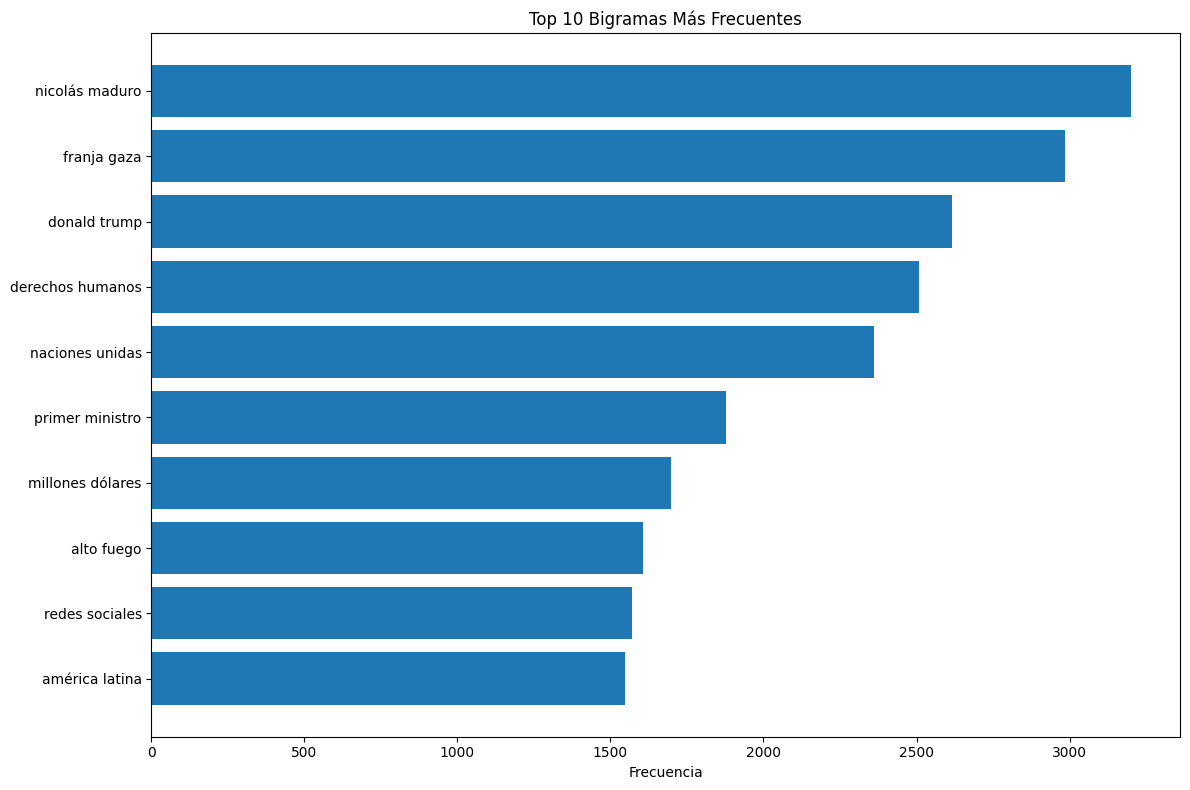

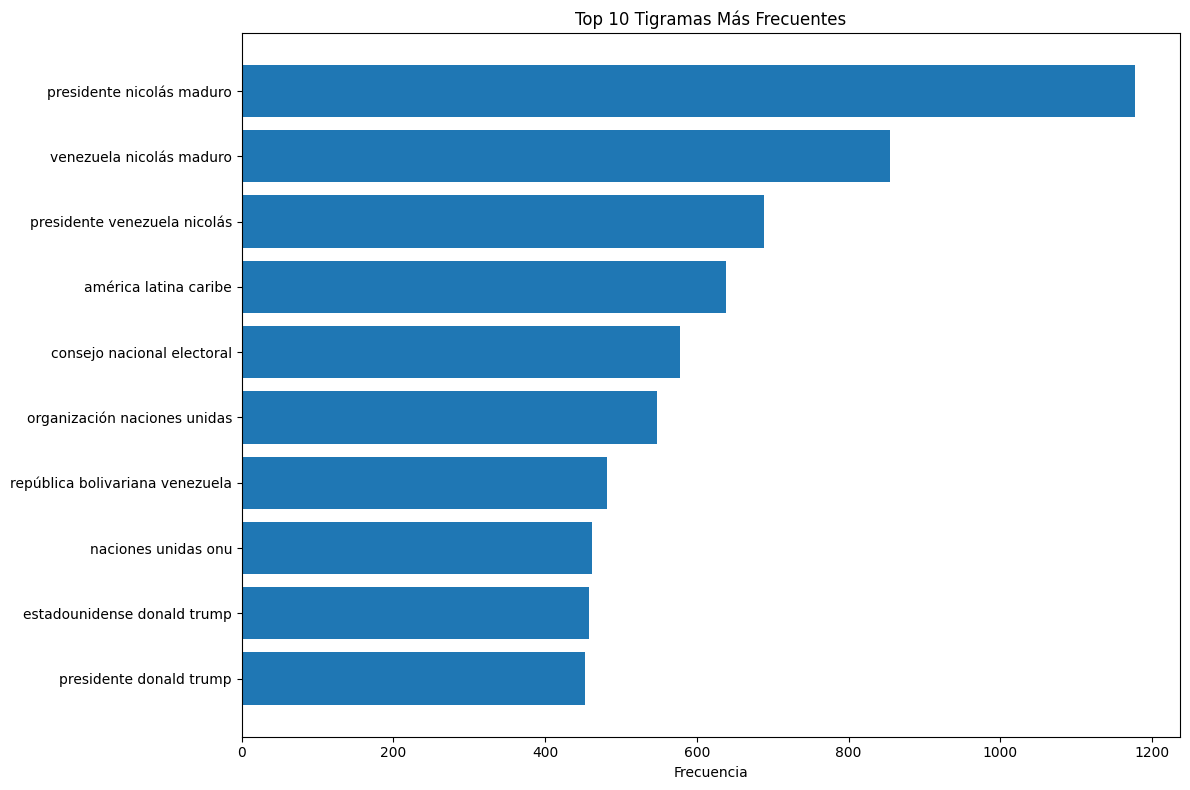

In [15]:

def analyze_ngrams(words, n=2, top_n=10):
    """
    Analiza n-gramas en una lista de palabras
    """
    n_grams = list(ngrams(words, n))
    n_gram_freq = Counter(n_grams)
    return n_gram_freq.most_common(top_n)

if clean_texts and 'words_filtered' in locals():
    print("ANÁLISIS DE N-GRAMAS:")
    print("="*50)
    
    bigrams = analyze_ngrams(words_filtered, n=2, top_n=10)
    print("\nTOP 10 BIGRAMAS:")
    print("-" * 30)
    for bigram, freq in bigrams:
        print(f"{' '.join(bigram):<25} : {freq:>3} veces")
    
    trigrams = analyze_ngrams(words_filtered, n=3, top_n=10)
    print("\nTOP 10 TRIGRAMAS:")
    print("-" * 30)
    for trigram, freq in trigrams:
        print(f"{' '.join(trigram):<35} : {freq:>3} veces")
    
    if bigrams:
        bigram_labels = [' '.join(bg[0]) for bg in bigrams[:10]]
        bigram_counts = [bg[1] for bg in bigrams[:10]]
        
        plt.figure(figsize=(12, 8))
        plt.barh(bigram_labels[::-1], bigram_counts[::-1])
        plt.title('Top 10 Bigramas Más Frecuentes')
        plt.xlabel('Frecuencia')
        plt.tight_layout()
        plt.show()
    if trigrams:
        trigrams_labels = [' '.join(bg[0]) for bg in trigrams[:10]]
        trigrams_counts = [bg[1] for bg in trigrams[:10]]
        
        plt.figure(figsize=(12, 8))
        plt.barh(trigrams_labels[::-1], trigrams_counts[::-1])
        plt.title('Top 10 Tigramas Más Frecuentes')
        plt.xlabel('Frecuencia')
        plt.tight_layout()
        plt.show()

## Análisis de Longitud de Textos y Oraciones

ANÁLISIS DE LONGITUDES:
TEXTOS (palabras):
  Promedio: 378.1 palabras
  Mediana: 330.0 palabras
  Mínimo: 0 palabras
  Máximo: 11036 palabras
  Desv. estándar: 258.0

TEXTOS (caracteres):
  Promedio: 2388 caracteres
  Mediana: 2084 caracteres
  Mínimo: 0 caracteres
  Máximo: 68427 caracteres

ORACIONES:
  Total de oraciones: 225451
  Promedio: 34.5 palabras por oración
  Mediana: 32.0 palabras por oración
  Mínimo: 1 palabras
  Máximo: 451 palabras


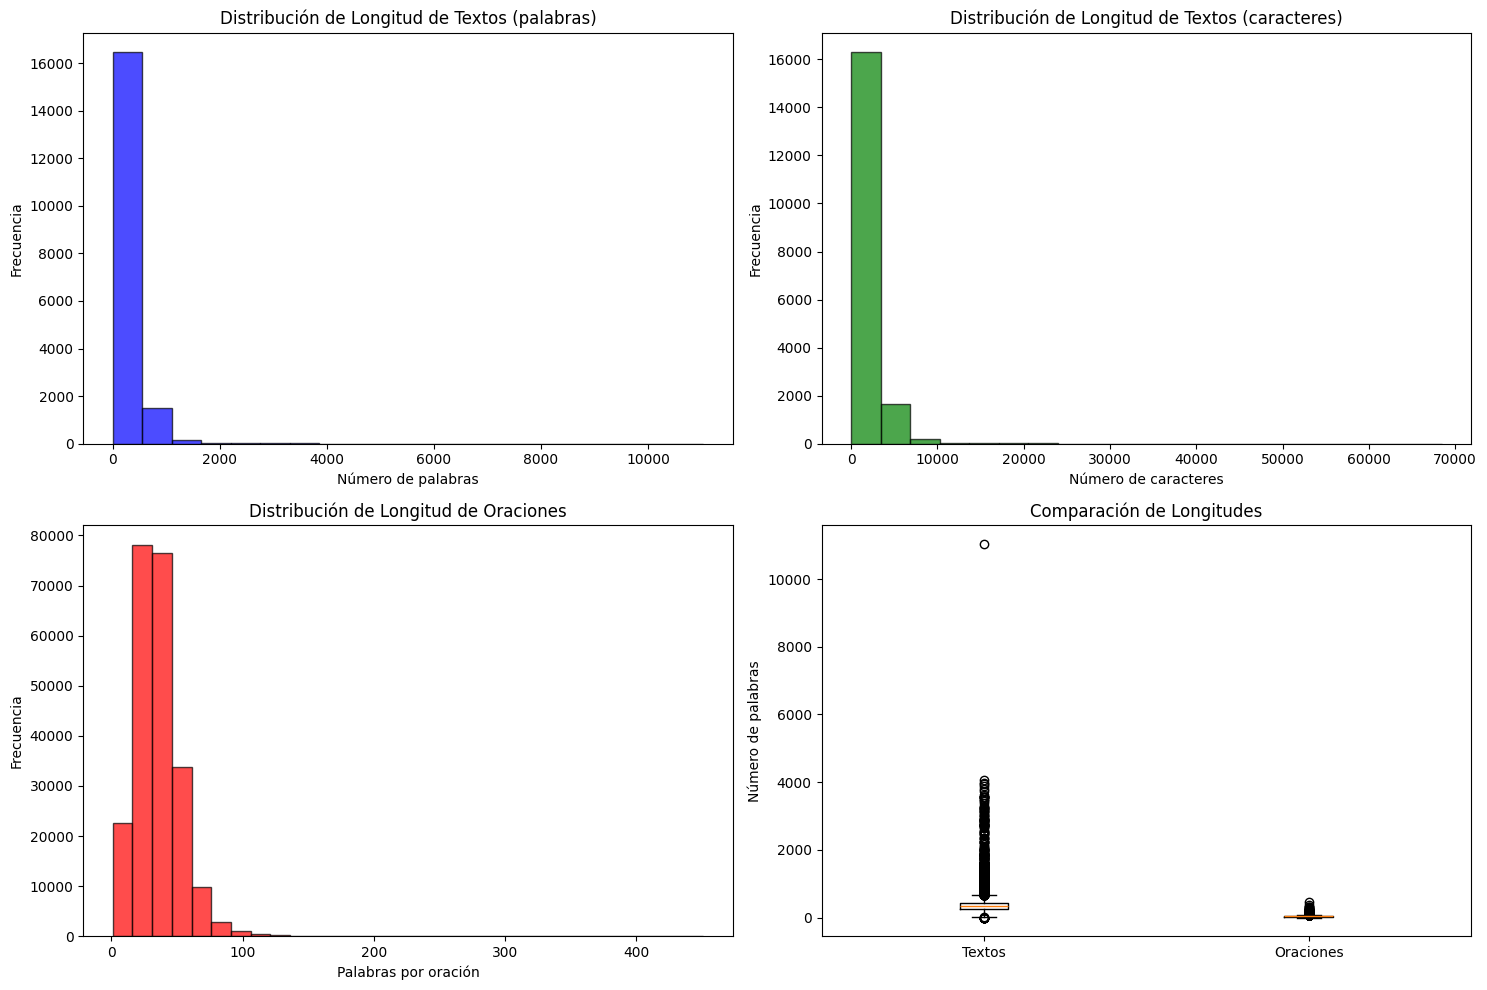

In [16]:

if clean_texts:
    text_lengths = [len(text.split()) for text in clean_texts]
    char_lengths = [len(text) for text in clean_texts]
    
    sentence_lengths = []
    for text in clean_texts:
        sentences = sent_tokenize(text, language='spanish')
        for sentence in sentences:
            words_in_sentence = len(word_tokenize(sentence, language='spanish'))
            if words_in_sentence > 0:
                sentence_lengths.append(words_in_sentence)
    
    print("ANÁLISIS DE LONGITUDES:")
    print("="*50)
    print(f"TEXTOS (palabras):")
    print(f"  Promedio: {np.mean(text_lengths):.1f} palabras")
    print(f"  Mediana: {np.median(text_lengths):.1f} palabras")
    print(f"  Mínimo: {np.min(text_lengths)} palabras")
    print(f"  Máximo: {np.max(text_lengths)} palabras")
    print(f"  Desv. estándar: {np.std(text_lengths):.1f}")
    
    print(f"\nTEXTOS (caracteres):")
    print(f"  Promedio: {np.mean(char_lengths):.0f} caracteres")
    print(f"  Mediana: {np.median(char_lengths):.0f} caracteres")
    print(f"  Mínimo: {np.min(char_lengths)} caracteres")
    print(f"  Máximo: {np.max(char_lengths)} caracteres")
    
    if sentence_lengths:
        print(f"\nORACIONES:")
        print(f"  Total de oraciones: {len(sentence_lengths)}")
        print(f"  Promedio: {np.mean(sentence_lengths):.1f} palabras por oración")
        print(f"  Mediana: {np.median(sentence_lengths):.1f} palabras por oración")
        print(f"  Mínimo: {np.min(sentence_lengths)} palabras")
        print(f"  Máximo: {np.max(sentence_lengths)} palabras")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0,0].hist(text_lengths, bins=20, alpha=0.7, color='blue', edgecolor='black')
    axes[0,0].set_title('Distribución de Longitud de Textos (palabras)')
    axes[0,0].set_xlabel('Número de palabras')
    axes[0,0].set_ylabel('Frecuencia')
    
    axes[0,1].hist(char_lengths, bins=20, alpha=0.7, color='green', edgecolor='black')
    axes[0,1].set_title('Distribución de Longitud de Textos (caracteres)')
    axes[0,1].set_xlabel('Número de caracteres')
    axes[0,1].set_ylabel('Frecuencia')
    
 
    if sentence_lengths:
        axes[1,0].hist(sentence_lengths, bins=30, alpha=0.7, color='red', edgecolor='black')
        axes[1,0].set_title('Distribución de Longitud de Oraciones')
        axes[1,0].set_xlabel('Palabras por oración')
        axes[1,0].set_ylabel('Frecuencia')
    
    box_data = [text_lengths, sentence_lengths[:len(text_lengths)] if sentence_lengths else []]
    axes[1,1].boxplot([text_lengths, sentence_lengths if sentence_lengths else [0]], 
                      labels=['Textos', 'Oraciones'])
    axes[1,1].set_title('Comparación de Longitudes')
    axes[1,1].set_ylabel('Número de palabras')
    
    plt.tight_layout()
    plt.show()

## Análisis de Diversidad Léxica y Complejidad

ANÁLISIS DE DIVERSIDAD LÉXICA:
Total de palabras: 4,773,644
Palabras únicas: 95,345
Type-Token Ratio (TTR): 0.0200
Índice de Simpson (diversidad): 0.9962
Longitud promedio de palabras: 6.62 caracteres
Interpretación TTR: Baja diversidad léxica


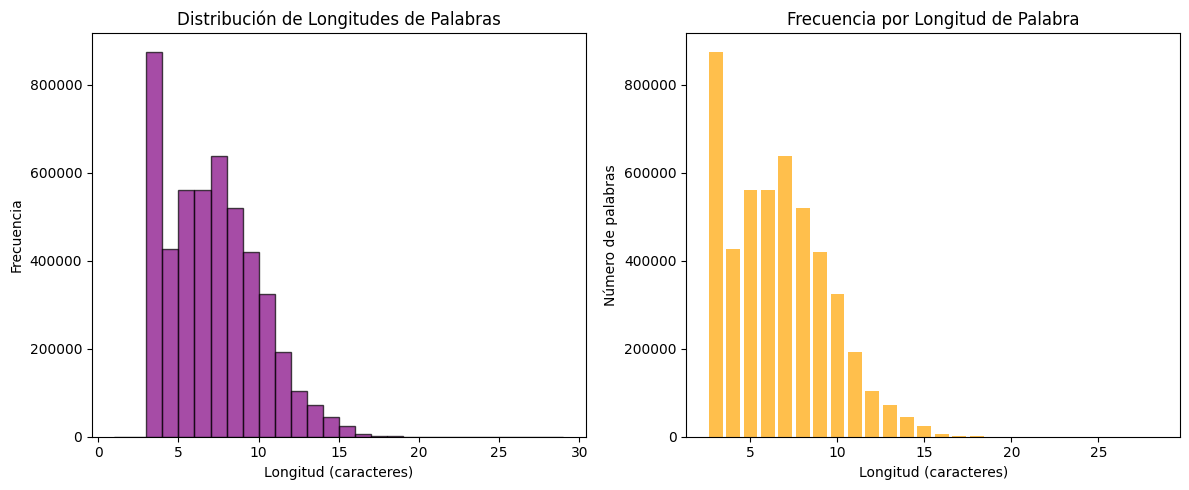

In [17]:

def calculate_lexical_diversity(texts):
    """
    Calcula métricas de diversidad léxica
    """
    all_text = ' '.join(texts)
    words = word_tokenize(all_text.lower(), language='spanish')
    words_clean = [w for w in words if w.isalpha() and len(w) > 2]
    
    total_words = len(words_clean)
    unique_words = len(set(words_clean))
    
    ttr = unique_words / total_words if total_words > 0 else 0
    
    word_freq = Counter(words_clean)
    n = sum(word_freq.values())
    simpson_index = sum((freq * (freq - 1)) for freq in word_freq.values()) / (n * (n - 1)) if n > 1 else 0
    simpson_diversity = 1 - simpson_index
    
    word_lengths = [len(word) for word in words_clean]
    avg_word_length = np.mean(word_lengths)
    
    return {
        'total_words': total_words,
        'unique_words': unique_words,
        'ttr': ttr,
        'simpson_diversity': simpson_diversity,
        'avg_word_length': avg_word_length,
        'word_lengths': word_lengths
    }

if clean_texts:
    lexical_stats = calculate_lexical_diversity(clean_texts)
    
    print("ANÁLISIS DE DIVERSIDAD LÉXICA:")
    print("="*50)
    print(f"Total de palabras: {lexical_stats['total_words']:,}")
    print(f"Palabras únicas: {lexical_stats['unique_words']:,}")
    print(f"Type-Token Ratio (TTR): {lexical_stats['ttr']:.4f}")
    print(f"Índice de Simpson (diversidad): {lexical_stats['simpson_diversity']:.4f}")
    print(f"Longitud promedio de palabras: {lexical_stats['avg_word_length']:.2f} caracteres")
    
    if lexical_stats['ttr'] > 0.7:
        interpretation = "Muy alta diversidad léxica"
    elif lexical_stats['ttr'] > 0.5:
        interpretation = "Alta diversidad léxica"
    elif lexical_stats['ttr'] > 0.3:
        interpretation = "Diversidad léxica moderada"
    else:
        interpretation = "Baja diversidad léxica"
    
    print(f"Interpretación TTR: {interpretation}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(lexical_stats['word_lengths'], bins=range(1, max(lexical_stats['word_lengths'])+2), 
             alpha=0.7, color='purple', edgecolor='black')
    plt.title('Distribución de Longitudes de Palabras')
    plt.xlabel('Longitud (caracteres)')
    plt.ylabel('Frecuencia')
    
    plt.subplot(1, 2, 2)
    length_counts = Counter(lexical_stats['word_lengths'])
    lengths = sorted(length_counts.keys())
    counts = [length_counts[l] for l in lengths]
    plt.bar(lengths, counts, alpha=0.7, color='orange')
    plt.title('Frecuencia por Longitud de Palabra')
    plt.xlabel('Longitud (caracteres)')
    plt.ylabel('Número de palabras')
    
    plt.tight_layout()
    plt.show()

##  Análisis Temporal de Contenido

ANÁLISIS TEMPORAL Y POR CATEGORÍAS:

DISTRIBUCIÓN POR SECCIONES:
América Latina y El Caribe: 9394 artículos,  374.2 palabras promedio
Mundo                    : 8039 artículos,  341.4 palabras promedio
En profundidad           :  265 artículos, 1547.5 palabras promedio
Deporte                  :  204 artículos,  307.2 palabras promedio
Cultura                  :  149 artículos,  351.2 palabras promedio
                         :   81 artículos, 1050.2 palabras promedio
Tecnología               :   61 artículos,  294.7 palabras promedio
Sin categoría            :   50 artículos,  235.7 palabras promedio
Lo mejor                 :    4 artículos,   56.5 palabras promedio
Video                    :    3 artículos,  112.3 palabras promedio


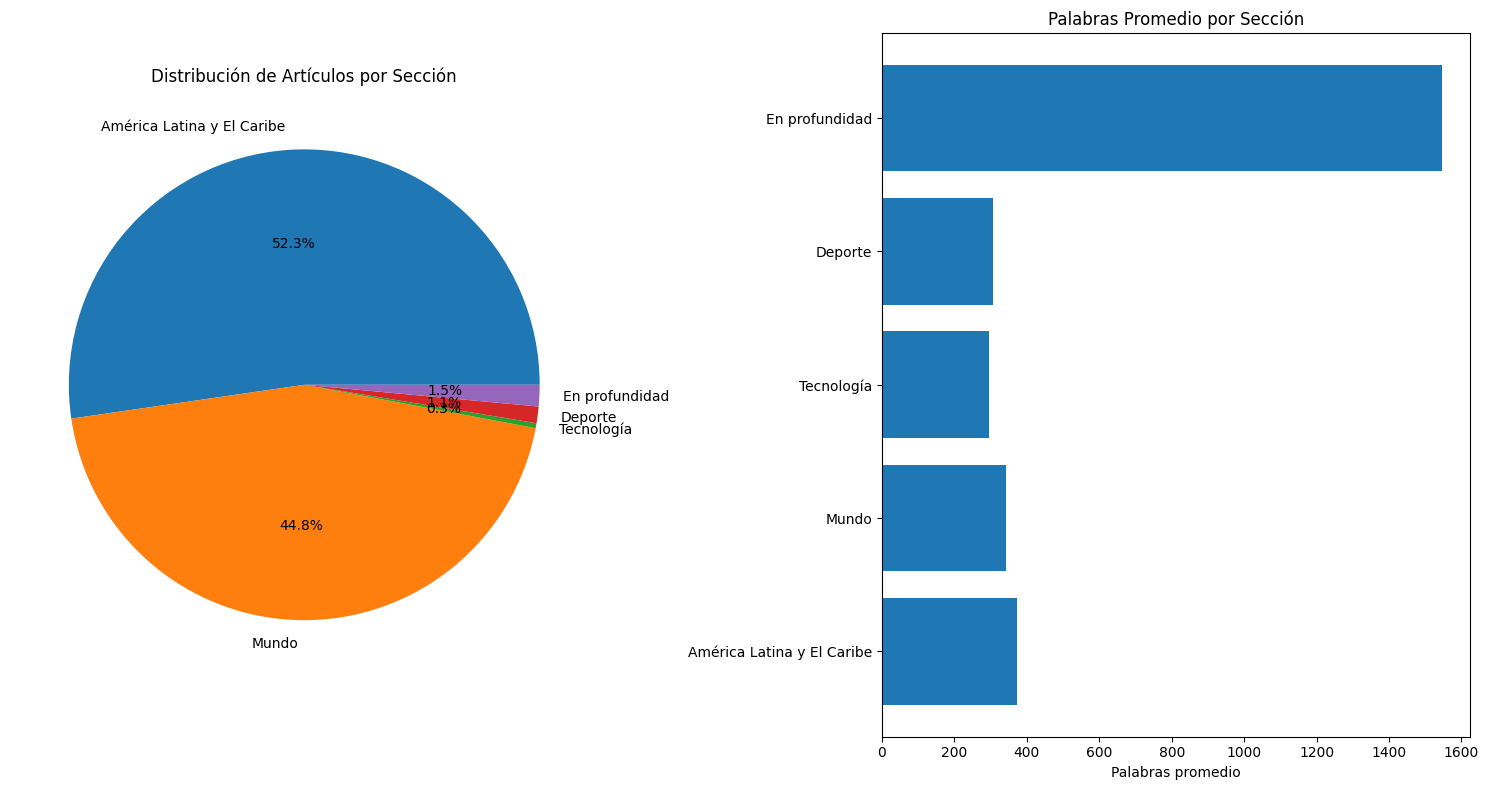

In [18]:

def analyze_temporal_patterns():
    """
    Analiza patrones temporales en el contenido de los artículos
    """
    temporal_data = []
    
    for article in articles:
        if isinstance(article, dict) and 'source_metadata' in article:
            metadata = article.get('source_metadata', {})
            date = metadata.get('date')
            text = article.get('text', '')
            
            if date and text:
                temporal_data.append({
                    'date': date,
                    'text_length': len(text.split()),
                    'char_length': len(text),
                    'text': text[:100] + "..." if len(text) > 100 else text
                })
    
    return temporal_data

def analyze_by_section():
    """
    Analiza el contenido por secciones
    """
    section_analysis = {}
    
    for article in articles:
        if isinstance(article, dict):
            section = article.get('section', 'Sin categoría')
            text = article.get('text', '')
            
            if section not in section_analysis:
                section_analysis[section] = {
                    'count': 0,
                    'total_words': 0,
                    'texts': []
                }
            
            section_analysis[section]['count'] += 1
            section_analysis[section]['total_words'] += len(text.split())
            section_analysis[section]['texts'].append(text)
    
    return section_analysis

print("ANÁLISIS TEMPORAL Y POR CATEGORÍAS:")
print("="*50)

section_stats = analyze_by_section()

print("\nDISTRIBUCIÓN POR SECCIONES:")
for section, data in sorted(section_stats.items(), key=lambda x: x[1]['count'], reverse=True):
    avg_words = data['total_words'] / data['count'] if data['count'] > 0 else 0
    print(f"{section:<25}: {data['count']:>4} artículos, {avg_words:>6.1f} palabras promedio")

if section_stats:
    sections = list(section_stats.keys())[:5] 
    counts = [section_stats[s]['count'] for s in sections]
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(1, 2, 1)
    plt.pie(counts, labels=sections, autopct='%1.1f%%')
    plt.title('Distribución de Artículos por Sección')
    
    plt.subplot(1, 2, 2)
    avg_words_by_section = [section_stats[s]['total_words']/section_stats[s]['count'] 
                           for s in sections]
    plt.barh(sections, avg_words_by_section)
    plt.title('Palabras Promedio por Sección')
    plt.xlabel('Palabras promedio')
    
    plt.tight_layout()
    plt.show()

## Modelado de Temas 

In [ ]:
import spacy
import pandas as pd
from collections import Counter
import re

class SpanishTextAnalyzer:
    def __init__(self):
        """Inicializar el analizador de texto en español con spaCy"""
        self._cargar_modelo_espanol()
        
    def _cargar_modelo_espanol(self):
        """Cargar modelo de spaCy para español"""
        try:
            self.nlp = spacy.load("es_core_news_sm")
            print("✓ Modelo spaCy español cargado exitosamente")
        except OSError:
            print("Instalando modelo spaCy español...")
            import os
            os.system("python -m spacy download es_core_news_sm")
            try:
                self.nlp = spacy.load("es_core_news_sm")
                print("✓ Modelo spaCy español cargado después de instalación")
            except:
                print("✗ Error: No se pudo cargar el modelo spaCy")
                self.nlp = None

    def analizar_texto_completo(self, texto):
        """
        Análisis completo de texto en español extraiendo todas las entidades
        y características relevantes usando spaCy
        """
        if self.nlp is None:
            return {"error": "Modelo no disponible"}
        
        doc = self.nlp(texto)
        
        resultado = {
            'texto_original': texto,
            'tokens': [],
            'entidades': [],
            'sintaxis': [],
            'morfologia': [],
            'estadisticas': {},
            'lemas': [],
            'dependencias': []
        }
        
        # Análisis a nivel de token
        for token in doc:
            token_info = {
                'texto': token.text,
                'lemma': token.lemma_,
                'pos': token.pos_,
                'tag': token.tag_,
                'dep': token.dep_,
                'es_alpha': token.is_alpha,
                'es_stop': token.is_stop,
                'es_puntuacion': token.is_punct,
                'es_numero': token.like_num,
                'forma': token.shape_
            }
            resultado['tokens'].append(token_info)
            
            # Información de sintaxis y dependencias
            if token.dep_ != "":
                resultado['dependencias'].append({
                    'token': token.text,
                    'dependencia': token.dep_,
                    'head': token.head.text
                })
        
        # Entidades nombradas
        for ent in doc.ents:
            entidad_info = {
                'texto': ent.text,
                'etiqueta': ent.label_,
                'explicacion': self._explicar_etiqueta_entidad(ent.label_),
                'inicio': ent.start_char,
                'fin': ent.end_char
            }
            resultado['entidades'].append(entidad_info)
        
        # Análisis morfológico
        for token in doc:
            if token.morph:
                morfologia = {
                    'token': token.text,
                    'morfologia': str(token.morph)
                }
                resultado['morfologia'].append(morfologia)
        
        # Estadísticas del texto
        resultado['estadisticas'] = self._calcular_estadisticas(doc)
        
        # Frases nominales (chunking)
        resultado['frases_nominales'] = [chunk.text for chunk in doc.noun_chunks]
        
        # Oraciones
        resultado['oraciones'] = [sent.text for sent in doc.sents]
        
        return resultado
    
    def _explicar_etiqueta_entidad(self, etiqueta):
        """Explicar el significado de las etiquetas de entidades"""
        explicaciones = {
            'PER': 'Persona',
            'LOC': 'Lugar',
            'ORG': 'Organización',
            'MISC': 'Misceláneo',
            'EVENT': 'Evento',
            'WORK_OF_ART': 'Obra de arte',
            'PRODUCT': 'Producto',
            'DATE': 'Fecha',
            'TIME': 'Tiempo',
            'MONEY': 'Dinero',
            'QUANTITY': 'Cantidad',
            'ORDINAL': 'Ordinal',
            'CARDINAL': 'Cardinal',
            'FAC': 'Instalación',
            'GPE': 'Entidad Geopolítica'
        }
        return explicaciones.get(etiqueta, 'Desconocido')
    
    def _calcular_estadisticas(self, doc):
        """Calcular estadísticas detalladas del texto"""
        tokens = [token for token in doc if not token.is_punct and not token.is_space]
        palabras = [token for token in tokens if token.is_alpha]
        stop_words = [token for token in palabras if token.is_stop]
        
        return {
            'total_tokens': len(doc),
            'total_palabras': len(palabras),
            'total_stop_words': len(stop_words),
            'total_entidades': len(doc.ents),
            'total_oraciones': len(list(doc.sents)),
            'total_frases_nominales': len(list(doc.noun_chunks)),
            'densidad_stop_words': len(stop_words) / len(palabras) if palabras else 0,
            'palabras_unicas': len(set([token.lemma_ for token in palabras])),
            'vocabulario_rico': len(set([token.lemma_ for token in palabras])) / len(palabras) if palabras else 0
        }
    
    def analizar_multiple_textos(self, textos):
        """Analizar múltiples textos y devolver resumen comparativo"""
        resultados = []
        estadisticas_totales = {
            'entidades_comunes': Counter(),
            'pos_comunes': Counter(),
            'total_textos': len(textos)
        }
        
        for texto in textos:
            analisis = self.analizar_texto_completo(texto)
            resultados.append(analisis)
            
            # Acumular estadísticas
            for entidad in analisis['entidades']:
                estadisticas_totales['entidades_comunes'][entidad['etiqueta']] += 1
            
            for token in analisis['tokens']:
                estadisticas_totales['pos_comunes'][token['pos']] += 1
        
        return {
            'analisis_individual': resultados,
            'resumen_comparativo': estadisticas_totales
        }
    
    def generar_reporte(self, texto):
        """Generar un reporte legible del análisis"""
        analisis = self.analizar_texto_completo(texto)
        
        print("=" * 80)
        print("ANÁLISIS COMPLETO DE TEXTO EN ESPAÑOL")
        print("=" * 80)
        print(f"Texto analizado: {analisis['texto_original']}\n")
        
        # Estadísticas principales
        stats = analisis['estadisticas']
        print("ESTADÍSTICAS PRINCIPALES:")
        print(f"- Total de palabras: {stats['total_palabras']}")
        print(f"- Total de oraciones: {stats['total_oraciones']}")
        print(f"- Palabras únicas: {stats['palabras_unicas']}")
        print(f"- Riqueza de vocabulario: {stats['vocabulario_rico']:.2%}")
        print(f"- Densidad de stop words: {stats['densidad_stop_words']:.2%}\n")
        
        # Entidades nombradas
        if analisis['entidades']:
            print("ENTIDADES NOMBRADAS ENCONTRADAS:")
            for ent in analisis['entidades']:
                print(f"- '{ent['texto']}': {ent['etiqueta']} ({ent['explicacion']})")
        else:
            print("No se encontraron entidades nombradas.")
        print()
        
        # Distribución POS
        pos_counts = Counter([token['pos'] for token in analisis['tokens']])
        print("DISTRIBUCIÓN DE CATEGORÍAS GRAMATICALES:")
        for pos, count in pos_counts.most_common():
            print(f"- {pos}: {count}")
        print()
        
        # Frases nominales
        if analisis['frases_nominales']:
            print("FRASES NOMINALES IDENTIFICADAS:")
            for frase in analisis['frases_nominales'][:10]:  # Mostrar solo las primeras 10
                print(f"- {frase}")
        print()
        
        return analisis


if __name__ == "__main__":
    
    analizador = SpanishTextAnalyzer()
    
    for i, texto in enumerate(clean_texts, 1):
        print(f"\n{'='*80}")
        print(f"ANÁLISIS {i}:")
        print('='*80)
        analizador.generar_reporte(texto)
    

    print("\n" + "="*80)
    print("ANÁLISIS DE TODOS LOS TEXTOS")
    print("="*80)
    
    analisis_comparativo = analizador.analizar_multiple_textos(clean_texts)
    resumen = analisis_comparativo['resumen_comparativo']
    
    print("ENTIDADES MÁS COMUNES:")
    for entidad, count in resumen['entidades_comunes'].most_common():
        print(f"- {entidad}: {count}")
    
    print("\nCATEGORÍAS GRAMATICALES MÁS COMUNES:")
    for pos, count in resumen['pos_comunes'].most_common():
        print(f"- {pos}: {count}")

✓ Modelo spaCy español cargado exitosamente

ANÁLISIS 1:
ANÁLISIS COMPLETO DE TEXTO EN ESPAÑOL
Texto analizado: la cámara de diputados de méxico aprobó este jueves la reforma constitucional que permitirá ceder al ejército mexicano el control de la guardia nacional , un cuerpo de seguridad de carácter civil-militar con más de 120.000 elementos que el presidente lópez obrador creó en 2019. el proyecto fue aprobado con 362 votos a favor, 133 en contra y 0 abstenciones, pasará al senado para su debate, en donde se prevé que será ratificado la semana próxima en vísperas del cambio de gobierno entre el presidente andrés manuel lópez obrador y la presidenta electa claudia sheinbaum. lópez obrador pondrá fin a su mandato con una nueva victoria legislativa, gracias a la mayoría oficialista en la cámara de diputados que el movimiento regeneración nacional (morena) obtuvo en las elecciones del pasado 2 de junio. la nueva reforma modifica 12 artículos de la constitución, confirma la desaparición d

In [ ]:
all_text = ' '.join(clean_texts)

In [ ]:
articles[0]

In [8]:
from collections import defaultdict
dic = defaultdict(list)
for i in articles:
    try:
        dic['url'].append(i.get('url', 'N/A'))
        dic['title'].append(i.get('title', 'N/A'))
        dic['tags'].append(i.get('tags', []))
        dic['text'].append(i.get('text', 'N/A'))
        dic['json_file'].append(i['source_metadata'].get('json_file', 'N/A') if 'source_metadata' in i else 'N/A')
        dic['date'].append(i['source_metadata'].get('date', 'N/A') if 'source_metadata' in i else 'N/A')
        dic['section'].append(i.get('section', 'N/A'))
        dic['views'].append(i['source_metadata'].get('views', 'N/A') if 'source_metadata' in i else 'N/A')
        dic['total_reactions'].append(i['source_metadata'].get('total_reactions', 'N/A') if 'source_metadata' in i else 'N/A')
    except Exception as e:
        print(f"Error procesando artículo: {e}")
df = pd.DataFrame(dic)
df.head()
    

Error procesando artículo: 'list' object has no attribute 'get'
Error procesando artículo: 'list' object has no attribute 'get'
Error procesando artículo: 'list' object has no attribute 'get'
Error procesando artículo: 'list' object has no attribute 'get'


,url,title,tags,text,json_file,date,section,views,total_reactions
0,https://www.telesurtv.net/camara-de-diputados-...,Cámara de Diputados de México aprueba el pase ...,"[Cámara de Diputados, Guardia Nacional, Presid...",La Cámara de Diputados de México aprobó este j...,Data/teleSUR_tv/2024/mensajes_teleSUR_tv_2024-...,2024-09-20T05:55:10+00:00,América Latina y El Caribe,2665,56
1,https://www.telesurtv.net/nicaragua-se-retira-...,Nicaragua se retira del Consejo de DD.HH. de l...,"[Consejo de Derechos Humanos, Nicaragua, ONU]",El Gobierno de Nicaragua informó este jueves s...,Data/teleSUR_tv/2025/mensajes_teleSUR_tv_2025-...,2025-02-28T09:55:12+00:00,América Latina y El Caribe,1905,58
2,https://www.telesurtv.net/kenia-aumentan-muert...,Kenia: Aumentan a 38 los fallecidos en protest...,"[Kenia, Muertes, Protestas Sociales]",La Comisión Nacional de Derechos Humanos de Ke...,Data/teleSUR_tv/2025/mensajes_teleSUR_tv_2025-...,2025-07-12T01:55:17+00:00,Mundo,1892,40
3,https://www.telesurtv.net/presidente-maduro-la...,Presidente Maduro: La lucha de Bolívar hoy se ...,"[bolivar, Brics, cumbre, Presidente Maduro]",\nEn su intervención ante la Asamblea Ampliada...,Data/teleSUR_tv/2024/mensajes_teleSUR_tv_2024-...,2024-10-24T18:28:20+00:00,Mundo,2842,77
4,https://www.telesurtv.net/disturbios-en-reino-...,Disturbios en Reino Unido dejan un hombre grav...,"[detenidos, Disturbios, Reino Unido]",\nUn hombre resultó gravemente herido y seis p...,Data/teleSUR_tv/2024/mensajes_teleSUR_tv_2024-...,2024-08-06T17:55:40+00:00,Mundo,2074,20


In [39]:
df.head()

,url,title,tags,text,json_file,date,section,views,total_reactions
0,https://www.telesurtv.net/camara-de-diputados-...,Cámara de Diputados de México aprueba el pase ...,"[Cámara de Diputados, Guardia Nacional, Presid...",La Cámara de Diputados de México aprobó este j...,Data/teleSUR_tv/2024/mensajes_teleSUR_tv_2024-...,2024-09-20T05:55:10+00:00,América Latina y El Caribe,2665,56
1,https://www.telesurtv.net/nicaragua-se-retira-...,Nicaragua se retira del Consejo de DD.HH. de l...,"[Consejo de Derechos Humanos, Nicaragua, ONU]",El Gobierno de Nicaragua informó este jueves s...,Data/teleSUR_tv/2025/mensajes_teleSUR_tv_2025-...,2025-02-28T09:55:12+00:00,América Latina y El Caribe,1905,58
2,https://www.telesurtv.net/kenia-aumentan-muert...,Kenia: Aumentan a 38 los fallecidos en protest...,"[Kenia, Muertes, Protestas Sociales]",La Comisión Nacional de Derechos Humanos de Ke...,Data/teleSUR_tv/2025/mensajes_teleSUR_tv_2025-...,2025-07-12T01:55:17+00:00,Mundo,1892,40
3,https://www.telesurtv.net/presidente-maduro-la...,Presidente Maduro: La lucha de Bolívar hoy se ...,"[bolivar, Brics, cumbre, Presidente Maduro]",\nEn su intervención ante la Asamblea Ampliada...,Data/teleSUR_tv/2024/mensajes_teleSUR_tv_2024-...,2024-10-24T18:28:20+00:00,Mundo,2842,77
4,https://www.telesurtv.net/disturbios-en-reino-...,Disturbios en Reino Unido dejan un hombre grav...,"[detenidos, Disturbios, Reino Unido]",\nUn hombre resultó gravemente herido y seis p...,Data/teleSUR_tv/2024/mensajes_teleSUR_tv_2024-...,2024-08-06T17:55:40+00:00,Mundo,2074,20


In [10]:
df.shape

(18250, 9)

In [ ]:

from nltk import CFG, ChartParser
import re
from collections import defaultdict, Counter
import pandas as pd

print("=== ANÁLISIS CON GRAMÁTICAS DE CONTEXTO LIBRE Y REGEX ===")

def create_news_grammar():
    """
    Crea una gramática de contexto libre para analizar estructuras típicas de noticias
    """
    grammar_rules = """
    S -> OPENING BODY CONCLUSION
    S -> OPENING BODY
    S -> BODY
    
    OPENING -> ENTITY ACTION_VERB COMPLEMENT
    OPENING -> TEMPORAL_PHRASE ENTITY ACTION_VERB
    OPENING -> INSTITUTION ANNOUNCE_VERB DECISION
    
    BODY -> DETAIL_LIST | QUOTE | EXPLANATION
    BODY -> BODY BODY
    
    CONCLUSION -> TEMPORAL_REF FUTURE_ACTION
    CONCLUSION -> CONSEQUENCE_PHRASE
    
    ENTITY -> PERSON | INSTITUTION | PLACE | GOVERNMENT
    PERSON -> 'presidente' | 'ministro' | 'diputado' | 'senador' | 'líder'
    INSTITUTION -> 'gobierno' | 'parlamento' | 'congreso' | 'asamblea' | 'cámara'
    PLACE -> 'méxico' | 'venezuela' | 'colombia' | 'argentina' | 'brasil' | 'chile'
    GOVERNMENT -> 'administración' | 'ejecutivo' | 'poder'
    
    ACTION_VERB -> 'aprobó' | 'decidió' | 'anunció' | 'declaró' | 'estableció'
    ANNOUNCE_VERB -> 'informó' | 'comunicó' | 'reveló' | 'manifestó'
    
    COMPLEMENT -> POLICY | DECISION | STATEMENT
    POLICY -> 'reforma' | 'ley' | 'proyecto' | 'iniciativa'
    DECISION -> 'resolución' | 'acuerdo' | 'medida' | 'determinación'
    
    TEMPORAL_PHRASE -> 'este' TEMPORAL_UNIT | 'la' TEMPORAL_UNIT | 'durante'
    TEMPORAL_UNIT -> 'jueves' | 'viernes' | 'semana' | 'mes' | 'año'
    
    QUOTE -> PERSON 'dijo' | PERSON 'afirmó' | PERSON 'señaló'
    
    DETAIL_LIST -> DETAIL | DETAIL DETAIL_LIST
    DETAIL -> NUMBER 'votos' | NUMBER 'personas' | NUMBER 'elementos'
    NUMBER -> 'uno' | 'dos' | 'cientos' | 'miles' | 'millones'
    
    FUTURE_ACTION -> 'pasará' | 'será' | 'continuará'
    CONSEQUENCE_PHRASE -> 'como' 'resultado' | 'en' 'consecuencia'
    """
    
    return CFG.fromstring(grammar_rules)


class NewsRegexAnalyzer:
    def __init__(self):
        # Patrones para fechas
        self.date_patterns = {
            'fecha_completa': r'\d{1,2}\s+de\s+\w+\s+de\s+\d{4}',
            'fecha_relativa': r'este\s+(lunes|martes|miércoles|jueves|viernes|sábado|domingo)',
            'fecha_temporal': r'(ayer|hoy|mañana|la\s+semana\s+pasada|el\s+mes\s+pasado)'
        }
        
        # Patrones para números y cantidades
        self.number_patterns = {
            'votos': r'(\d+)\s+votos?\s+(a\s+favor|en\s+contra)',
            'porcentajes': r'(\d+(?:\.\d+)?)\s*%',
            'dinero': r'(\d+(?:\.\d+)?)\s*(millones?|miles?)\s*(de\s+)?(dólares?|pesos?|euros?)',
            'personas': r'(\d+(?:\.\d+)?)\s*(mil|millones?)\s*(de\s+)?(personas?|habitantes?|ciudadanos?)',
            'años': r'(\d{4})',
            'edades': r'(\d+)\s+años?'
        }
        
        # Patrones para entidades nombradas específicas
        self.entity_patterns = {
            'presidentes': r'(presidente|presidenta)\s+([A-ZÁÉÍÓÚ][a-záéíóúñü]+(?:\s+[A-ZÁÉÍÓÚ][a-záéíóúñü]+)*)',
            'ministros': r'(ministro|ministra)\s+([A-ZÁÉÍÓÚ][a-záéíóúñü]+(?:\s+[A-ZÁÉÍÓÚ][a-záéíóúñü]+)*)',
            'instituciones': r'(Cámara\s+de\s+Diputados|Senado|Congreso|Asamblea\s+Nacional|Gobierno)',
            'partidos': r'(Movimiento\s+Regeneración\s+Nacional|Morena|PRI|PAN|PRD)',
            'países': r'(México|Venezuela|Colombia|Argentina|Brasil|Chile|Perú|Ecuador|Bolivia|Uruguay|Paraguay)',
            'organizaciones': r'(ONU|OEA|CELAC|UNASUR|MERCOSUR|BRICS)'
        }
        
        # Patrones para acciones y eventos
        self.action_patterns = {
            'aprobaciones': r'(aprobó|aprobaron|ratificó|ratificaron)\s+([^.]+)',
            'rechazos': r'(rechazó|rechazaron|negó|negaron)\s+([^.]+)',
            'anuncios': r'(anunció|anunciaron|informó|informaron)\s+([^.]+)',
            'declaraciones': r'(declaró|declararon|afirmó|afirmaron|señaló|señalaron)\s+([^.]+)',
            'decisiones': r'(decidió|decidieron|determinó|determinaron)\s+([^.]+)'
        }
        
        # Patrones para contexto político
        self.political_patterns = {
            'reformas': r'reforma\s+(constitucional|legal|judicial|electoral|económica)',
            'leyes': r'(ley|proyecto\s+de\s+ley)\s+([^.]+)',
            'elecciones': r'elecciones?\s+(presidenciales?|legislativas?|municipales?)',
            'protestas': r'(protestas?|manifestaciones?|marchas?)\s+([^.]+)',
            'conflictos': r'(conflicto|crisis|tensión)\s+([^.]+)'
        }

    def extract_patterns(self, text):
        """Extrae todos los patrones definidos del texto"""
        results = {}
        
        # Extraer cada tipo de patrón
        for category, patterns in [
            ('fechas', self.date_patterns),
            ('números', self.number_patterns),
            ('entidades', self.entity_patterns),
            ('acciones', self.action_patterns),
            ('política', self.political_patterns)
        ]:
            results[category] = {}
            for pattern_name, pattern in patterns.items():
                matches = re.findall(pattern, text, re.IGNORECASE)
                if matches:
                    results[category][pattern_name] = matches
        
        return results

    def analyze_text_structure(self, text):
        """Analiza la estructura general del texto"""
        # Dividir en oraciones
        sentences = sent_tokenize(text, language='spanish')
        
        structure_analysis = {
            'total_sentences': len(sentences),
            'opening_indicators': [],
            'temporal_markers': [],
            'citation_patterns': [],
            'conclusion_markers': []
        }
        
        # Patrones estructurales
        opening_patterns = [r'^(El|La|Los|Las)\s+\w+', r'Este\s+(lunes|martes|miércoles|jueves|viernes)']
        temporal_patterns = [r'(ayer|hoy|mañana|esta\s+semana|el\s+mes\s+pasado)']
        citation_patterns = [r'"([^"]+)"', r'(dijo|afirmó|señaló|declaró)\s+([^.]+)']
        conclusion_patterns = [r'(finalmente|en\s+conclusión|por\s+último|como\s+resultado)']
        
        # Analizar cada oración
        for i, sentence in enumerate(sentences):
            # Identificar oraciones de apertura
            for pattern in opening_patterns:
                if re.search(pattern, sentence, re.IGNORECASE) and i == 0:
                    structure_analysis['opening_indicators'].append(sentence[:50] + "...")
            
            # Identificar marcadores temporales
            for pattern in temporal_patterns:
                matches = re.findall(pattern, sentence, re.IGNORECASE)
                structure_analysis['temporal_markers'].extend(matches)
            
            # Identificar citas
            for pattern in citation_patterns:
                matches = re.findall(pattern, sentence, re.IGNORECASE)
                structure_analysis['citation_patterns'].extend(matches)
            
            # Identificar conclusiones
            for pattern in conclusion_patterns:
                if re.search(pattern, sentence, re.IGNORECASE):
                    structure_analysis['conclusion_markers'].append(sentence[:50] + "...")
        
        return structure_analysis


news_grammar = create_news_grammar()
print(f"✓ Gramática creada con {len(news_grammar.productions())} reglas de producción")

analyzer = NewsRegexAnalyzer()

print("\n=== GRAMÁTICA DE CONTEXTO LIBRE PARA NOTICIAS ===")
print("Reglas de producción principales:")
for i, production in enumerate(news_grammar.productions()[:10]):
    print(f"  {i+1}. {production}")
if len(news_grammar.productions()) > 10:
    print(f"  ... y {len(news_grammar.productions()) - 10} reglas más")

print("\n✅ Sistema de análisis configurado exitosamente!")

=== ANÁLISIS CON GRAMÁTICAS DE CONTEXTO LIBRE Y REGEX ===
✓ Gramática creada con 81 reglas de producción
✓ Analizador de expresiones regulares inicializado

=== GRAMÁTICA DE CONTEXTO LIBRE PARA NOTICIAS ===
Reglas de producción principales:
  1. S -> OPENING BODY CONCLUSION
  2. S -> OPENING BODY
  3. S -> BODY
  4. OPENING -> ENTITY ACTION_VERB COMPLEMENT
  5. OPENING -> TEMPORAL_PHRASE ENTITY ACTION_VERB
  6. OPENING -> INSTITUTION ANNOUNCE_VERB DECISION
  7. BODY -> DETAIL_LIST
  8. BODY -> QUOTE
  9. BODY -> EXPLANATION
  10. BODY -> BODY BODY
  ... y 71 reglas más

✅ Sistema de análisis configurado exitosamente!


In [ ]:

def analyze_news_corpus(df, max_articles=50):
    """Analiza todo el corpus de noticias"""
    
    
    global_patterns = defaultdict(Counter)
    structural_stats = defaultdict(list)
    
    print(f"Analizando {min(max_articles, len(df))} artículos...")
    
    
    for idx, row in df.head(max_articles).iterrows():
        text = row['text']
        if pd.isna(text) or len(text) < 50:
            continue
        
        # Extraer patrones
        patterns = analyzer.extract_patterns(text)
        
        # Acumular patrones
        for category, subcategories in patterns.items():
            for pattern_name, matches in subcategories.items():
                global_patterns[category][pattern_name] += len(matches)
        
        # Análisis estructural
        structure = analyzer.analyze_text_structure(text)
        for key, value in structure.items():
            if isinstance(value, list):
                structural_stats[key].extend(value)
            else:
                structural_stats[key].append(value)
    
    return global_patterns, structural_stats


print("=== ANÁLISIS COMPLETO DEL CORPUS ===")
global_patterns, structural_stats = analyze_news_corpus(df, max_articles=50)

# Mostrar resultados generales
print(f"\n=== RESULTADOS DEL ANÁLISIS REGEX ===")

# Mostrar patrones más frecuentes por categoría
for category, patterns in global_patterns.items():
    if patterns:  # Solo mostrar categorías con resultados
        print(f"\n🔍 {category.upper()}:")
        for pattern_name, count in patterns.most_common(3):
            print(f"   • {pattern_name}: {count} ocurrencias")

print(f"\n=== ANÁLISIS ESTRUCTURAL ===")
if structural_stats['total_sentences']:
    print(f"• Promedio de oraciones por texto: {np.mean(structural_stats['total_sentences']):.1f}")
print(f"• Textos con indicadores de apertura: {len(structural_stats['opening_indicators'])}")
print(f"• Total de marcadores temporales: {len(structural_stats['temporal_markers'])}")
print(f"• Total de patrones de citas: {len(structural_stats['citation_patterns'])}")

# Mostrar algunos marcadores temporales únicos
if structural_stats['temporal_markers']:
    unique_temporal = list(set(structural_stats['temporal_markers']))[:5]
    print(f"• Ejemplos de marcadores temporales: {unique_temporal}")

print(f"\n=== PATRONES REGEX MÁS EFECTIVOS ===")

# Evaluar efectividad de patrones
effective_patterns = []
for category, patterns in global_patterns.items():
    for pattern_name, count in patterns.items():
        if count > 0:  # Todos los patrones encontrados
            effective_patterns.append((category, pattern_name, count))

effective_patterns.sort(key=lambda x: x[2], reverse=True)

print("Top 10 patrones más frecuentes:")
for i, (category, pattern, count) in enumerate(effective_patterns[:10], 1):
    print(f"{i:2}. {category}/{pattern}: {count} ocurrencias")

print(f"\n✅ Análisis del corpus completado!")

=== ANÁLISIS COMPLETO DEL CORPUS ===
Analizando 50 artículos...

=== RESULTADOS DEL ANÁLISIS REGEX ===

🔍 FECHAS:
   • fecha_relativa: 33 ocurrencias
   • fecha_temporal: 11 ocurrencias
   • fecha_completa: 8 ocurrencias

🔍 NÚMEROS:
   • años: 65 ocurrencias
   • edades: 14 ocurrencias
   • porcentajes: 5 ocurrencias

🔍 ENTIDADES:
   • países: 113 ocurrencias
   • partidos: 64 ocurrencias
   • presidentes: 62 ocurrencias

🔍 ACCIONES:
   • declaraciones: 33 ocurrencias
   • anuncios: 17 ocurrencias
   • rechazos: 5 ocurrencias

🔍 POLÍTICA:
   • protestas: 17 ocurrencias
   • conflictos: 10 ocurrencias
   • leyes: 4 ocurrencias

=== ANÁLISIS ESTRUCTURAL ===
• Promedio de oraciones por texto: 12.0
• Textos con indicadores de apertura: 42
• Total de marcadores temporales: 10
• Total de patrones de citas: 35
• Ejemplos de marcadores temporales: ['hoy', 'esta semana', 'Hoy']

=== PATRONES REGEX MÁS EFECTIVOS ===
Top 10 patrones más frecuentes:
 1. entidades/países: 113 ocurrencias
 2. número

In [ ]:

print("=== ANÁLISIS DETALLADO DE ARTÍCULOS ESPECÍFICOS ===")

def analyze_article_in_detail(article_index, df, analyzer):
    """Analiza un artículo específico en detalle"""
    
    if article_index >= len(df):
        print(f"❌ Índice {article_index} fuera de rango")
        return
    
    row = df.iloc[article_index]
    text = row['text']
    title = row['title']
    
    print(f"\n📰 ARTÍCULO {article_index + 1}")
    print("═" * 80)
    print(f"TÍTULO: {title}")
    print(f"FECHA: {row.get('date', 'No disponible')}")
    print(f"LONGITUD: {len(text)} caracteres")
    print("─" * 80)
    
    # Extraer patrones específicos
    patterns = analyzer.extract_patterns(text)
    
    # Mostrar patrones encontrados
    print("🔍 PATRONES EXTRAÍDOS:")
    found_patterns = False
    for category, subcategories in patterns.items():
        if subcategories:  # Solo mostrar categorías con resultados
            found_patterns = True
            print(f"  📋 {category.upper()}:")
            for pattern_name, matches in subcategories.items():
                if matches:
                    # Mostrar solo los primeros 3 matches para evitar spam
                    display_matches = matches[:3]
                    if len(matches) > 3:
                        display_matches.append(f"... y {len(matches) - 3} más")
                    print(f"    • {pattern_name}: {display_matches}")
    
    if not found_patterns:
        print("    ➤ No se encontraron patrones específicos")
    
    # Análisis estructural
    structure = analyzer.analyze_text_structure(text)
    print(f"\n📊 ANÁLISIS ESTRUCTURAL:")
    print(f"  • Número de oraciones: {structure['total_sentences']}")
    
    if structure['temporal_markers']:
        print(f"  • Marcadores temporales: {structure['temporal_markers']}")
    
    if structure['citation_patterns']:
        print(f"  • Patrones de citas encontrados: {len(structure['citation_patterns'])}")
        # Mostrar algunas citas
        for i, citation in enumerate(structure['citation_patterns'][:2]):
            if isinstance(citation, tuple):
                print(f"    └─ Cita {i+1}: {citation}")
    
    if structure['opening_indicators']:
        print(f"  • Indicadores de apertura: {structure['opening_indicators']}")
    
    if structure['conclusion_markers']:
        print(f"  • Marcadores de conclusión: {structure['conclusion_markers']}")
    
    # Mostrar fragmento del texto
    print(f"\n📝 FRAGMENTO DEL TEXTO (primeros 300 caracteres):")
    print(f"'{text[:300]}{'...' if len(text) > 300 else ''}'")
    
    print("\n" + "─" * 80)

# Analizar los primeros 3 artículos en detalle
for i in range(min(3, len(df))):
    analyze_article_in_detail(i, df, analyzer)


=== ANÁLISIS DETALLADO DE ARTÍCULOS ESPECÍFICOS ===

📰 ARTÍCULO 1
════════════════════════════════════════════════════════════════════════════════
TÍTULO: Cámara de Diputados de México aprueba el pase de la Guardia Nacional al Ejército - teleSUR
FECHA: 2024-09-20T05:55:10+00:00
LONGITUD: 1521 caracteres
────────────────────────────────────────────────────────────────────────────────
🔍 PATRONES EXTRAÍDOS:
  📋 FECHAS:
    • fecha_relativa: ['jueves']
  📋 NÚMEROS:
    • votos: [('362', 'a favor')]
    • años: ['2019']
  📋 ENTIDADES:
    • presidentes: [('presidente', 'López Obrador creó en'), ('presidente', 'Andrés Manuel López Obrador'), ('presidenta', 'electa Claudia Sheinbaum')]
    • instituciones: ['Cámara de Diputados', 'Senado', 'Gobierno', '... y 1 más']
    • partidos: ['Movimiento Regeneración Nacional', 'Morena']
    • países: ['México']
  📋 ACCIONES:
    • aprobaciones: [('aprobó', 'este jueves la reforma constitucional que permitirá ceder al Ejército mexicano el control de la

In [ ]:

print("=== SISTEMA EXPANDIDO DE GRAMÁTICAS Y REGEX ===")

def create_comprehensive_news_grammar():
    """
    Crea una gramática de contexto libre EXPANDIDA y más comprehensiva
    """
    grammar_rules = """
    # ESTRUCTURA PRINCIPAL DE NOTICIAS
    S -> HEADLINE LEAD BODY CONCLUSION
    S -> HEADLINE LEAD BODY
    S -> LEAD BODY CONCLUSION
    S -> LEAD BODY
    S -> BODY CONCLUSION
    S -> BODY
    
    # ESTRUCTURA DE TITULARES
    HEADLINE -> ENTITY ACTION_PHRASE
    HEADLINE -> LOCATION_PHRASE ACTION_PHRASE
    HEADLINE -> TEMPORAL_MARKER ACTION_PHRASE
    HEADLINE -> BREAKING_NEWS ACTION_PHRASE
    
    # ESTRUCTURA DE ENTRADILLA/LEAD
    LEAD -> TEMPORAL_CONTEXT MAIN_ACTION CONTEXT
    LEAD -> LOCATION_CONTEXT MAIN_ACTION
    LEAD -> MAIN_ACTION CONTEXT
    LEAD -> ATTRIBUTION MAIN_ACTION
    
    # CUERPO DE LA NOTICIA
    BODY -> PARAGRAPH_LIST
    BODY -> QUOTE_SECTION EXPLANATION_SECTION
    BODY -> CONTEXT_SECTION QUOTE_SECTION
    BODY -> DATA_SECTION CONTEXT_SECTION
    
    PARAGRAPH_LIST -> PARAGRAPH | PARAGRAPH PARAGRAPH_LIST
    PARAGRAPH -> TOPIC_SENTENCE SUPPORTING_SENTENCES
    PARAGRAPH -> TRANSITION_PHRASE TOPIC_SENTENCE
    
    # SECCIONES ESPECIALIZADAS
    QUOTE_SECTION -> DIRECT_QUOTE | INDIRECT_QUOTE | QUOTE_SEQUENCE
    QUOTE_SEQUENCE -> DIRECT_QUOTE ATTRIBUTION | ATTRIBUTION DIRECT_QUOTE
    
    EXPLANATION_SECTION -> BACKGROUND_INFO | STATISTICAL_DATA | EXPERT_ANALYSIS
    DATA_SECTION -> NUMERICAL_INFO | COMPARATIVE_DATA | TREND_ANALYSIS
    CONTEXT_SECTION -> HISTORICAL_CONTEXT | POLITICAL_CONTEXT | ECONOMIC_CONTEXT
    
    # CONCLUSIONES Y CIERRES
    CONCLUSION -> FUTURE_IMPLICATIONS | SUMMARY_STATEMENT | CALL_TO_ACTION
    CONCLUSION -> EXPERT_PREDICTION | POLICY_OUTCOME | NEXT_STEPS
    
    # ENTIDADES POLÍTICAS EXPANDIDAS
    ENTITY -> POLITICAL_FIGURE | INSTITUTION | ORGANIZATION | PARTY
    POLITICAL_FIGURE -> HEAD_OF_STATE | MINISTER | LEGISLATOR | JUDGE | CANDIDATE
    
    HEAD_OF_STATE -> 'presidente' | 'presidenta' | 'primer' 'ministro' | 'primera' 'ministra' | 'canciller'
    MINISTER -> 'ministro' | 'ministra' | 'secretario' | 'secretaria' | 'titular'
    LEGISLATOR -> 'diputado' | 'diputada' | 'senador' | 'senadora' | 'congresista' | 'asambleísta'
    JUDGE -> 'juez' | 'jueza' | 'magistrado' | 'magistrada' | 'fiscal'
    CANDIDATE -> 'candidato' | 'candidata' | 'aspirante' | 'precandidato' | 'precandidáta'
    
    # INSTITUCIONES EXPANDIDAS
    INSTITUTION -> GOVERNMENT_BODY | COURT_SYSTEM | ELECTORAL_BODY | REGULATORY_AGENCY
    
    GOVERNMENT_BODY -> 'gobierno' | 'administración' | 'ejecutivo' | 'gabinete' | 'consejo' 'de' 'ministros'
    COURT_SYSTEM -> 'tribunal' | 'corte' | 'juzgado' | 'sala' | 'cámara'
    ELECTORAL_BODY -> 'instituto' 'electoral' | 'tribunal' 'electoral' | 'consejo' 'electoral'
    REGULATORY_AGENCY -> 'comisión' | 'superintendencia' | 'autoridad' | 'agencia'
    
    # ORGANIZACIONES AMPLIADAS
    ORGANIZATION -> INTERNATIONAL_ORG | CIVIL_SOCIETY | BUSINESS_ORG | MEDIA_ORG
    
    INTERNATIONAL_ORG -> 'onu' | 'oea' | 'celac' | 'unasur' | 'mercosur' | 'brics' | 'g20' | 'fmi' | 'banco' 'mundial'
    CIVIL_SOCIETY -> 'ong' | 'fundación' | 'asociación' | 'sindicato' | 'colegio' 'profesional'
    BUSINESS_ORG -> 'cámara' 'de' 'comercio' | 'confederación' | 'gremio' | 'asociación' 'empresarial'
    MEDIA_ORG -> 'cadena' | 'canal' | 'periódico' | 'agencia' 'de' 'noticias' | 'medio'
    
    # PARTIDOS POLÍTICOS EXPANDIDOS
    PARTY -> MAJOR_PARTY | MINOR_PARTY | COALITION | MOVEMENT
    
    MAJOR_PARTY -> 'morena' | 'pri' | 'pan' | 'prd' | 'mc' | 'pvem' | 'pt'
    MINOR_PARTY -> 'nueva' 'alianza' | 'encuentro' 'social' | 'redes' 'sociales' 'progresistas'
    COALITION -> 'coalición' | 'alianza' | 'frente' | 'bloque'
    MOVEMENT -> 'movimiento' | 'plataforma' | 'corriente' | 'grupo' 'político'
    
    # LUGARES GEOGRÁFICOS EXPANDIDOS
    LOCATION -> COUNTRY | STATE | CITY | REGION | CONTINENT
    
    COUNTRY -> LATIN_AMERICA | NORTH_AMERICA | EUROPE | AFRICA | ASIA
    LATIN_AMERICA -> 'méxico' | 'venezuela' | 'colombia' | 'argentina' | 'brasil' | 'chile' | 'perú' | 'ecuador' | 'bolivia' | 'uruguay' | 'paraguay' | 'costa' 'rica' | 'panamá' | 'guatemala' | 'honduras' | 'el' 'salvador' | 'nicaragua' | 'cuba' | 'república' 'dominicana'
    NORTH_AMERICA -> 'estados' 'unidos' | 'canadá' | 'ee.uu.' | 'eua'
    EUROPE -> 'españa' | 'francia' | 'alemania' | 'italia' | 'reino' 'unido' | 'rusia'
    AFRICA -> 'sudáfrica' | 'nigeria' | 'egipto' | 'marruecos'
    ASIA -> 'china' | 'india' | 'japón' | 'corea' 'del' 'sur' | 'irán'
    
    STATE -> 'cdmx' | 'jalisco' | 'nuevo' 'león' | 'puebla' | 'guanajuato' | 'veracruz' | 'yucatán'
    CITY -> 'ciudad' 'de' 'méxico' | 'guadalajara' | 'monterrey' | 'puebla' | 'tijuana' | 'cancún'
    REGION -> 'américa' 'latina' | 'centroamérica' | 'caribe' | 'cono' 'sur' | 'andino' | 'amazonia'
    CONTINENT -> 'américa' | 'europa' | 'asia' | 'áfrica' | 'oceanía'
    
    # ACCIONES Y VERBOS EXPANDIDOS
    ACTION_PHRASE -> GOVERNMENT_ACTION | LEGISLATIVE_ACTION | JUDICIAL_ACTION | ELECTORAL_ACTION
    MAIN_ACTION -> ACTION_VERB COMPLEMENT | COMPLEX_ACTION
    
    GOVERNMENT_ACTION -> EXECUTIVE_VERB | ADMINISTRATIVE_VERB | DIPLOMATIC_VERB
    EXECUTIVE_VERB -> 'aprobó' | 'firmó' | 'promulgó' | 'vetó' | 'suspendió' | 'revocó' | 'implementó'
    ADMINISTRATIVE_VERB -> 'designó' | 'nombró' | 'destituyó' | 'trasladó' | 'reorganizó' | 'creó'
    DIPLOMATIC_VERB -> 'negoció' | 'acordó' | 'ratificó' | 'denunció' | 'retiró' | 'expulsó'
    
    LEGISLATIVE_ACTION -> LEGISLATIVE_VERB | PARLIAMENTARY_VERB
    LEGISLATIVE_VERB -> 'debatió' | 'votó' | 'modificó' | 'enmendó' | 'dictaminó' | 'presentó'
    PARLIAMENTARY_VERB -> 'sesionó' | 'convocó' | 'clausuró' | 'prorrogó' | 'interpelación'
    
    JUDICIAL_ACTION -> COURT_VERB | LEGAL_VERB
    COURT_VERB -> 'sentenció' | 'condenó' | 'absolvió' | 'procesó' | 'investigó' | 'imputó'
    LEGAL_VERB -> 'demandó' | 'apeló' | 'recurrió' | 'sobreseído' | 'prescribió'
    
    ELECTORAL_ACTION -> CAMPAIGN_VERB | VOTING_VERB
    CAMPAIGN_VERB -> 'candidateó' | 'postuló' | 'registró' | 'promovió' | 'financió'
    VOTING_VERB -> 'votó' | 'eligió' | 'reeligió' | 'referendó' | 'consultó'
    
    # COMPLEMENTOS EXPANDIDOS
    COMPLEMENT -> POLICY_ITEM | LEGAL_ITEM | ECONOMIC_ITEM | SOCIAL_ITEM
    
    POLICY_ITEM -> LAW_TYPE | PROGRAM_TYPE | AGREEMENT_TYPE
    LAW_TYPE -> 'ley' | 'decreto' | 'reglamento' | 'norma' | 'código' | 'estatuto'
    PROGRAM_TYPE -> 'programa' | 'plan' | 'proyecto' | 'iniciativa' | 'estrategia' | 'política'
    AGREEMENT_TYPE -> 'tratado' | 'convenio' | 'acuerdo' | 'protocolo' | 'memorando'
    
    LEGAL_ITEM -> REFORM_TYPE | PROCEDURE_TYPE
    REFORM_TYPE -> 'reforma' REFORM_AREA
    REFORM_AREA -> 'constitucional' | 'electoral' | 'judicial' | 'fiscal' | 'laboral' | 'energética'
    PROCEDURE_TYPE -> 'juicio' | 'proceso' | 'procedimiento' | 'investigación' | 'auditoría'
    
    ECONOMIC_ITEM -> BUDGET_TYPE | TRADE_TYPE | FINANCIAL_TYPE
    BUDGET_TYPE -> 'presupuesto' | 'gasto' | 'inversión' | 'subsidio' | 'impuesto'
    TRADE_TYPE -> 'comercio' | 'exportación' | 'importación' | 'aranceles' | 'tlc'
    FINANCIAL_TYPE -> 'deuda' | 'déficit' | 'superávit' | 'inflación' | 'tipo' 'de' 'cambio'
    
    SOCIAL_ITEM -> SOCIAL_PROGRAM | EDUCATION_ITEM | HEALTH_ITEM
    SOCIAL_PROGRAM -> 'asistencia' 'social' | 'becas' | 'pensiones' | 'vivienda' | 'empleo'
    EDUCATION_ITEM -> 'educación' | 'universidad' | 'escuela' | 'maestros' | 'estudiantes'
    HEALTH_ITEM -> 'salud' | 'hospital' | 'medicamentos' | 'vacunas' | 'epidemia'
    
    # CONTEXTO TEMPORAL EXPANDIDO
    TEMPORAL_CONTEXT -> TIME_REFERENCE | TEMPORAL_SEQUENCE | DURATION
    TEMPORAL_MARKER -> TIME_ADVERB | DATE_REFERENCE | PERIOD_REFERENCE
    
    TIME_REFERENCE -> SPECIFIC_TIME | RELATIVE_TIME | CYCLICAL_TIME
    SPECIFIC_TIME -> DAY_OF_WEEK | MONTH | SEASON | YEAR_REFERENCE
    DAY_OF_WEEK -> 'lunes' | 'martes' | 'miércoles' | 'jueves' | 'viernes' | 'sábado' | 'domingo'
    MONTH -> 'enero' | 'febrero' | 'marzo' | 'abril' | 'mayo' | 'junio' | 'julio' | 'agosto' | 'septiembre' | 'octubre' | 'noviembre' | 'diciembre'
    SEASON -> 'primavera' | 'verano' | 'otoño' | 'invierno'
    YEAR_REFERENCE -> 'año' | 'ejercicio' | 'período' | 'sexenio' | 'mandato'
    
    RELATIVE_TIME -> 'ayer' | 'hoy' | 'mañana' | 'anteayer' | 'pasado' 'mañana'
    CYCLICAL_TIME -> 'cada' TIME_UNIT | 'todos' 'los' DAY_OF_WEEK
    TIME_UNIT -> 'día' | 'semana' | 'mes' | 'año' | 'trimestre' | 'semestre'
    
    TEMPORAL_SEQUENCE -> 'antes' | 'después' | 'durante' | 'mientras' | 'cuando' | 'hasta' | 'desde'
    DURATION -> 'por' TIME_SPAN | 'durante' TIME_SPAN
    TIME_SPAN -> NUMBER TIME_UNIT | 'varios' TIME_UNIT | 'algunos' TIME_UNIT
    
    # ATRIBUCIÓN Y FUENTES EXPANDIDAS
    ATTRIBUTION -> SOURCE_TYPE VERB_OF_SAYING | VERB_OF_SAYING SOURCE_TYPE
    
    SOURCE_TYPE -> OFFICIAL_SOURCE | MEDIA_SOURCE | EXPERT_SOURCE | ANONYMOUS_SOURCE
    OFFICIAL_SOURCE -> 'gobierno' | 'ministerio' | 'presidencia' | 'congreso' | 'tribunal'
    MEDIA_SOURCE -> 'agencia' | 'periódico' | 'televisión' | 'radio' | 'portal'
    EXPERT_SOURCE -> 'analista' | 'especialista' | 'académico' | 'investigador' | 'consultor'
    ANONYMOUS_SOURCE -> 'fuentes' | 'voceros' | 'funcionarios' | 'allegados'
    
    VERB_OF_SAYING -> 'dijo' | 'declaró' | 'afirmó' | 'señaló' | 'manifestó' | 'expresó' | 'comentó' | 'reveló' | 'confirmó' | 'negó' | 'admitió' | 'reconoció'
    
    # CITAS Y DECLARACIONES
    DIRECT_QUOTE -> QUOTE_MARKER STATEMENT QUOTE_MARKER
    INDIRECT_QUOTE -> VERB_OF_SAYING 'que' STATEMENT
    STATEMENT -> ASSERTION | OPINION | PREDICTION | EXPLANATION
    
    ASSERTION -> FACT_CLAIM | POSITION_STATEMENT
    OPINION -> EVALUATION | JUDGMENT | PREFERENCE
    PREDICTION -> FUTURE_EVENT | CONSEQUENCE | EXPECTATION
    EXPLANATION -> REASON | JUSTIFICATION | CLARIFICATION
    
    QUOTE_MARKER -> '"' | "'" | '«' | '»'
    
    # NÚMEROS Y CANTIDADES EXPANDIDAS
    NUMBER -> CARDINAL | ORDINAL | FRACTION | PERCENTAGE
    CARDINAL -> 'uno' | 'dos' | 'tres' | 'cuatro' | 'cinco' | 'diez' | 'cien' | 'mil' | 'millón' | 'millones' | 'billón'
    ORDINAL -> 'primero' | 'segundo' | 'tercero' | 'último' | 'penúltimo'
    FRACTION -> 'medio' | 'tercio' | 'cuarto' | 'quinto'
    PERCENTAGE -> NUMBER 'por' 'ciento' | NUMBER '%'
    
    # DATOS ESTADÍSTICOS
    NUMERICAL_INFO -> QUANTITY_EXPRESSION | STATISTICAL_MEASURE | COMPARATIVE_FIGURE
    QUANTITY_EXPRESSION -> NUMBER UNIT_OF_MEASURE
    UNIT_OF_MEASURE -> 'votos' | 'personas' | 'pesos' | 'dólares' | 'euros' | 'metros' | 'kilómetros' | 'años'
    
    STATISTICAL_MEASURE -> AVERAGE | MEDIAN | GROWTH_RATE | INDEX
    AVERAGE -> 'promedio' | 'media'
    MEDIAN -> 'mediana'
    GROWTH_RATE -> 'crecimiento' | 'incremento' | 'disminución' | 'reducción'
    INDEX -> 'índice' | 'indicador' | 'tasa' | 'nivel'
    
    # TRANSICIONES Y CONECTORES
    TRANSITION_PHRASE -> CAUSAL_CONNECTOR | TEMPORAL_CONNECTOR | CONTRAST_CONNECTOR | ADDITION_CONNECTOR
    
    CAUSAL_CONNECTOR -> 'por' 'tanto' | 'en' 'consecuencia' | 'debido' 'a' | 'como' 'resultado'
    TEMPORAL_CONNECTOR -> 'posteriormente' | 'anteriormente' | 'simultáneamente' | 'finalmente'
    CONTRAST_CONNECTOR -> 'sin' 'embargo' | 'no' 'obstante' | 'por' 'el' 'contrario' | 'mientras' 'que'
    ADDITION_CONNECTOR -> 'además' | 'asimismo' | 'por' 'otra' 'parte' | 'igualmente'
    
    # CONTEXTOS ESPECIALIZADOS
    HISTORICAL_CONTEXT -> 'históricamente' | 'tradicionalmente' | 'precedente' | 'antecedente'
    POLITICAL_CONTEXT -> 'políticamente' | 'estratégicamente' | 'tácticamente' | 'ideológicamente'
    ECONOMIC_CONTEXT -> 'económicamente' | 'financieramente' | 'comercialmente' | 'fiscalmente'
    
    # IMPLICACIONES FUTURAS
    FUTURE_IMPLICATIONS -> PREDICTION | CONSEQUENCE | PROJECTION
    PREDICTION -> 'se' 'espera' | 'se' 'prevé' | 'se' 'anticipa' | 'se' 'proyecta'
    CONSEQUENCE -> 'resultará' 'en' | 'llevará' 'a' | 'provocará' | 'generará'
    PROJECTION -> 'tendencia' | 'escenario' | 'perspectiva' | 'pronóstico'
    
    # MARCADORES DE NOTICIA URGENTE
    BREAKING_NEWS -> 'último' 'momento' | 'urgente' | 'noticia' 'de' 'última' 'hora' | 'breaking'
    
    # ELEMENTOS DE CONTEXTO GEOPOLÍTICO
    LOCATION_CONTEXT -> 'en' LOCATION | 'desde' LOCATION | 'hacia' LOCATION
    LOCATION_PHRASE -> LOCATION_CONTEXT | SPECIFIC_LOCATION
    SPECIFIC_LOCATION -> CAPITAL | BORDER | INTERNATIONAL_VENUE
    
    CAPITAL -> 'ciudad' 'de' 'méxico' | 'washington' | 'brasilia' | 'buenos' 'aires' | 'bogotá'
    BORDER -> 'frontera' | 'límite' | 'aduana' | 'paso' 'fronterizo'
    INTERNATIONAL_VENUE -> 'sede' | 'cumbre' | 'foro' | 'conferencia' | 'asamblea'
    """
    
    return CFG.fromstring(grammar_rules)

class AdvancedNewsRegexAnalyzer:
    def __init__(self):
        # 1. PATRONES TEMPORALES EXPANDIDOS
        self.temporal_patterns = {
            # Fechas específicas
            'fecha_completa': r'\d{1,2}\s+de\s+(?:enero|febrero|marzo|abril|mayo|junio|julio|agosto|septiembre|octubre|noviembre|diciembre)\s+de\s+\d{4}',
            'fecha_corta': r'\d{1,2}[/-]\d{1,2}[/-]\d{2,4}',
            'fecha_americana': r'\d{1,2}/\d{1,2}/\d{2,4}',
            
            # Referencias temporales relativas
            'tiempo_relativo': r'(ayer|hoy|mañana|anteayer|pasado\s+mañana)',
            'semana_relativa': r'(esta\s+semana|la\s+semana\s+pasada|la\s+próxima\s+semana)',
            'mes_relativo': r'(este\s+mes|el\s+mes\s+pasado|el\s+próximo\s+mes)',
            'año_relativo': r'(este\s+año|el\s+año\s+pasado|el\s+próximo\s+año)',
            
            # Días de la semana
            'dias_semana': r'(lunes|martes|miércoles|jueves|viernes|sábado|domingo)',
            'dias_especificos': r'(este|el\s+próximo|el\s+pasado)\s+(lunes|martes|miércoles|jueves|viernes|sábado|domingo)',
            
            # Períodos específicos
            'periodos_gobierno': r'(sexenio|mandato|administración|gestión|período\s+presidencial)',
            'periodos_legislativos': r'(legislatura|período\s+ordinario|período\s+extraordinario|sesión)',
            
            # Horarios
            'horarios': r'\d{1,2}:\d{2}(?:\s*(?:am|pm|hrs|horas))?',
            'rangos_horarios': r'de\s+\d{1,2}:\d{2}\s+a\s+\d{1,2}:\d{2}'
        }
        
        # 2. NÚMEROS Y CANTIDADES EXPANDIDOS
        self.numerical_patterns = {
            # Votos y elecciones
            'votos_favor': r'(\d+(?:,\d{3})*)\s+votos?\s+(?:a\s+favor|en\s+pro)',
            'votos_contra': r'(\d+(?:,\d{3})*)\s+votos?\s+(?:en\s+contra|opositores)',
            'votos_abstencion': r'(\d+(?:,\d{3})*)\s+abstenciones?',
            'mayoría': r'mayoría\s+(?:de\s+)?(\d+)\s+votos?',
            
            # Porcentajes
            'porcentajes_exactos': r'(\d+(?:\.\d+)?)\s*%',
            'porcentajes_aproximados': r'(?:cerca\s+del|aproximadamente|alrededor\s+del)\s+(\d+(?:\.\d+)?)\s*%',
            
            # Dinero y presupuestos
            'pesos_mexicanos': r'(\d+(?:,\d{3})*(?:\.\d+)?)\s*(?:pesos?\s+mexicanos?|MXN|\$\s*MX)',
            'dolares': r'(\d+(?:,\d{3})*(?:\.\d+)?)\s*(?:dólares?|USD|\$\s*(?:USD|dólares?))',
            'euros': r'(\d+(?:,\d{3})*(?:\.\d+)?)\s*(?:euros?|EUR|€)',
            'millones_pesos': r'(\d+(?:,\d{3})*(?:\.\d+)?)\s*millones?\s+de\s+pesos',
            'billones': r'(\d+(?:,\d{3})*(?:\.\d+)?)\s*(?:billones?|bn)',
            
            # Cantidades de personas
            'habitantes': r'(\d+(?:,\d{3})*(?:\.\d+)?)\s*(?:mil|millones?)\s+(?:de\s+)?habitantes?',
            'ciudadanos': r'(\d+(?:,\d{3})*(?:\.\d+)?)\s*(?:mil|millones?)\s+(?:de\s+)?ciudadanos?',
            'beneficiarios': r'(\d+(?:,\d{3})*(?:\.\d+)?)\s*(?:mil|millones?)\s+(?:de\s+)?beneficiarios?',
            'empleados': r'(\d+(?:,\d{3})*(?:\.\d+)?)\s*(?:mil|millones?)\s+(?:de\s+)?(?:empleados?|trabajadores?)',
            
            # Años y edades
            'años_especificos': r'(?:en\s+el\s+año\s+|año\s+)?(\d{4})',
            'rangos_años': r'(?:entre\s+|desde\s+)?(\d{4})\s*(?:y|a|hasta)\s*(\d{4})',
            'edades': r'(\d+)\s+años?\s+de\s+edad',
            'generaciones': r'(?:generación|cohorte)\s+(\d{4})',
            
            # Medidas y distancias
            'kilometros': r'(\d+(?:,\d{3})*(?:\.\d+)?)\s*(?:kilómetros?|km)',
            'metros': r'(\d+(?:,\d{3})*(?:\.\d+)?)\s*metros?',
            'hectareas': r'(\d+(?:,\d{3})*(?:\.\d+)?)\s*hectáreas?'
        }
        
        # 3. ENTIDADES POLÍTICAS EXPANDIDAS
        self.political_entities = {
            # Cargos ejecutivos
            'presidentes': r'(?:presidente|presidenta)\s+([A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+(?:\s+[A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+)*)',
            'vicepresidentes': r'(?:vicepresidente|vicepresidenta)\s+([A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+(?:\s+[A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+)*)',
            'ministros': r'(?:ministro|ministra|secretario|secretaria)\s+([A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+(?:\s+[A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+)*)',
            'gobernadores': r'(?:gobernador|gobernadora)\s+([A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+(?:\s+[A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+)*)',
            'alcaldes': r'(?:alcalde|alcaldesa|jefe\s+de\s+gobierno)\s+([A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+(?:\s+[A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+)*)',
            
            # Cargos legislativos
            'diputados': r'(?:diputado|diputada)\s+([A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+(?:\s+[A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+)*)',
            'senadores': r'(?:senador|senadora)\s+([A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+(?:\s+[A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+)*)',
            'congresistas': r'(?:congresista)\s+([A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+(?:\s+[A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+)*)',
            
            # Cargos judiciales
            'jueces': r'(?:juez|jueza|magistrado|magistrada)\s+([A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+(?:\s+[A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+)*)',
            'fiscales': r'(?:fiscal|procurador|procuradora)\s+([A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+(?:\s+[A-ZÁÉÍÓÚÑÜ][a-záéíóúñü]+)*)',
            
            # Instituciones gubernamentales
            'instituciones_ejecutivas': r'(Presidencia|Gobierno\s+Federal|Poder\s+Ejecutivo|Administración\s+Pública|Gabinete)',
            'instituciones_legislativas': r'(Congreso\s+de\s+la\s+Unión|Cámara\s+de\s+Diputados|Senado\s+de\s+la\s+República|Poder\s+Legislativo)',
            'instituciones_judiciales': r'(Suprema\s+Corte|Poder\s+Judicial|Tribunal|Juzgado\s+Federal|Fiscalía\s+General)',
            'instituciones_electorales': r'(INE|Instituto\s+Nacional\s+Electoral|TEPJF|Tribunal\s+Electoral)',
            
            # Organismos autónomos
            'organismos_autonomos': r'(INEGI|CNDH|Banco\s+de\s+México|INAI|CRE|COFECE|CONEVAL)',
            
            # Partidos políticos mexicanos
            'partidos_mayores': r'(MORENA|PRI|PAN|PRD|MC|Movimiento\s+Ciudadano)',
            'partidos_menores': r'(PVEM|PT|Partido\s+del\s+Trabajo|Nueva\s+Alianza|Encuentro\s+Social|RSP)',
            'coaliciones': r'(Juntos\s+Haremos\s+Historia|Va\s+por\s+México|Coalición\s+[A-ZÁÉÍÓÚÑÜ][a-záéíóúñü\s]+)',
            
            # Países latinoamericanos
            'paises_latam': r'(México|Venezuela|Colombia|Argentina|Brasil|Chile|Perú|Ecuador|Bolivia|Uruguay|Paraguay|Costa\s+Rica|Panamá|Guatemala|Honduras|El\s+Salvador|Nicaragua|Cuba|República\s+Dominicana)',
            'paises_norteamerica': r'(Estados\s+Unidos|Canadá|EE\.?UU\.?|USA)',
            'paises_europa': r'(España|Francia|Alemania|Italia|Reino\s+Unido|Rusia|Portugal)',
            
            # Organizaciones internacionales
            'org_globales': r'(ONU|Naciones\s+Unidas|FMI|Banco\s+Mundial|OMC|G20|G7)',
            'org_regionales': r'(OEA|CELAC|UNASUR|MERCOSUR|ALADI|SICA|Alianza\s+del\s+Pacífico)',
            'org_comerciales': r'(T-MEC|TLCAN|NAFTA|TPP|CPTPP)',
        }
        
        # 4. ACCIONES GUBERNAMENTALES EXPANDIDAS
        self.government_actions = {
            # Acciones ejecutivas
            'aprobaciones': r'(aprobó|ratificó|sancionó|promulgó|firmó|rubricó)\s+([^.]+)',
            'rechazos': r'(rechazó|vetó|desechó|negó|denegó|desaprobó)\s+([^.]+)',
            'suspensiones': r'(suspendió|pausó|congeló|aplazó|pospuso)\s+([^.]+)',
            'implementaciones': r'(implementó|ejecutó|puso\s+en\s+marcha|estableció)\s+([^.]+)',
            
            # Acciones legislativas
            'presentaciones': r'(presentó|propuso|sometió|introdujo)\s+([^.]+)',
            'debates': r'(debatió|discutió|analizó|examinó)\s+([^.]+)',
            'votaciones': r'(votó|sufragó|eligió|decidió)\s+([^.]+)',
            'modificaciones': r'(modificó|enmendó|reformó|cambió)\s+([^.]+)',
            
            # Acciones judiciales
            'sentencias': r'(sentenció|condenó|absolvió|falló)\s+([^.]+)',
            'investigaciones': r'(investigó|indagó|pesquisó|averiguó)\s+([^.]+)',
            'procesamientos': r'(procesó|enjuició|imputó|acusó)\s+([^.]+)',
            
            # Declaraciones oficiales
            'anuncios': r'(anunció|comunicó|informó|reveló|divulgó)\s+([^.]+)',
            'declaraciones': r'(declaró|afirmó|manifestó|expresó|señaló)\s+([^.]+)',
            'confirmaciones': r'(confirmó|corroboró|ratificó|validó)\s+([^.]+)',
            'negaciones': r'(negó|desmintió|refutó|contradijo)\s+([^.]+)',
            
            # Acciones administrativas
            'nombramientos': r'(nombró|designó|eligió|seleccionó)\s+([^.]+)',
            'destituciones': r'(destituyó|removió|cesó|separó\s+del\s+cargo)\s+([^.]+)',
            'reorganizaciones': r'(reorganizó|reestructuró|modificó)\s+([^.]+)',
        }
        
        # 5. CONTEXTO POLÍTICO EXPANDIDO
        self.political_context = {
            # Tipos de reformas
            'reformas_constitucionales': r'reforma\s+(constitucional|a\s+la\s+constitución)',
            'reformas_electorales': r'reforma\s+(electoral|al\s+sistema\s+electoral)',
            'reformas_judiciales': r'reforma\s+(judicial|al\s+poder\s+judicial)',
            'reformas_energeticas': r'reforma\s+(energética|del\s+sector\s+energético)',
            'reformas_fiscales': r'reforma\s+(fiscal|tributaria|hacendaria)',
            'reformas_laborales': r'reforma\s+(laboral|del\s+trabajo)',
            'reformas_educativas': r'reforma\s+(educativa|del\s+sistema\s+educativo)',
            'reformas_salud': r'reforma\s+(de\s+salud|del\s+sistema\s+de\s+salud)',
            
            # Tipos de leyes
            'leyes_generales': r'(ley\s+general|código)\s+([^.]+)',
            'proyectos_ley': r'(?:proyecto|iniciativa)\s+de\s+ley\s+([^.]+)',
            'decretos': r'decreto\s+([^.]+)',
            'reglamentos': r'reglamento\s+([^.]+)',
            
            # Procesos electorales
            'elecciones_federales': r'elecciones?\s+(federales?|nacionales?|presidenciales?)',
            'elecciones_locales': r'elecciones?\s+(locales?|estatales?|municipales?)',
            'consultas': r'(consulta\s+popular|referéndum|plebiscito)',
            'campañas': r'campaña\s+(electoral|política)\s+([^.]+)',
            
            # Protestas y movimientos sociales
            'manifestaciones': r'(manifestación|protesta|marcha|concentración)\s+([^.]+)',
            'huelgas': r'huelga\s+([^.]+)',
            'bloqueos': r'bloqueo\s+([^.]+)',
            'paros': r'paro\s+([^.]+)',
            
            # Crisis y conflictos
            'crisis_politicas': r'crisis\s+(política|gubernamental|institucional)',
            'crisis_economicas': r'crisis\s+(económica|financiera|fiscal)',
            'conflictos_internos': r'conflicto\s+(interno|político|social)',
            'tensiones': r'tensión\s+([^.]+)',
            
            # Corrupción y transparencia
            'casos_corrupcion': r'(corrupción|fraude|malversación|peculado)\s+([^.]+)',
            'investigaciones_corrupcion': r'investigación\s+por\s+(corrupción|fraude)',
            'transparencia': r'(transparencia|rendición\s+de\s+cuentas|acceso\s+a\s+la\s+información)',
            
            # Políticas públicas
            'programas_sociales': r'programa\s+(social|de\s+bienestar|asistencial)\s+([^.]+)',
            'politicas_economicas': r'política\s+(económica|fiscal|monetaria)\s+([^.]+)',
            'politicas_publicas': r'política\s+pública\s+([^.]+)',
        }
        
        # 6. INDICADORES ECONÓMICOS
        self.economic_indicators = {
            'inflacion': r'inflación\s+(?:de|del)\s+(\d+(?:\.\d+)?)\s*%',
            'crecimiento_pib': r'(?:crecimiento\s+del\s+)?PIB\s+(?:de|del)\s+(\d+(?:\.\d+)?)\s*%',
            'desempleo': r'(?:tasa\s+de\s+)?desempleo\s+(?:de|del)\s+(\d+(?:\.\d+)?)\s*%',
            'tipo_cambio': r'(?:tipo\s+de\s+cambio|dólar)\s+(?:de|a)\s+(\d+(?:\.\d+)?)\s*pesos',
            'deficit_fiscal': r'déficit\s+fiscal\s+(?:de|del)\s+(\d+(?:\.\d+)?)\s*%',
            'deuda_publica': r'deuda\s+pública\s+(?:de|del)\s+(\d+(?:\.\d+)?)\s*%',
            'inversion_extranjera': r'inversión\s+extranjera\s+(?:de|por)\s+(\d+(?:,\d{3})*(?:\.\d+)?)\s*(?:millones?|billones?)',
        }
        
        # 7. PATRONES DE CITAS Y ATRIBUCIÓN
        self.citation_patterns = {
            'citas_directas': r'"([^"]+)"',
            'citas_con_comillas_latinas': r'«([^»]+)»',
            'declaraciones_directas': r'(declaró|afirmó|dijo|manifestó|expresó|señaló)\s*:\s*"([^"]+)"',
            'segun_fuentes': r'según\s+(fuentes|voceros|funcionarios|allegados)\s+([^,]+)',
            'comunicados_oficiales': r'(?:comunicado|boletín|pronunciamiento)\s+oficial',
            'ruedas_prensa': r'(?:rueda|conferencia)\s+de\s+prensa',
            'entrevistas': r'entrevista\s+(?:con|a)\s+([^,]+)',
        }

    def extract_all_patterns(self, text):
        """Extrae todos los patrones expandidos del texto"""
        results = {
            'temporal': {},
            'numerical': {},
            'political_entities': {},
            'government_actions': {},
            'political_context': {},
            'economic_indicators': {},
            'citations': {}
        }
        
        # Mapear cada categoría con sus patrones
        pattern_categories = [
            ('temporal', self.temporal_patterns),
            ('numerical', self.numerical_patterns),
            ('political_entities', self.political_entities),
            ('government_actions', self.government_actions),
            ('political_context', self.political_context),
            ('economic_indicators', self.economic_indicators),
            ('citations', self.citation_patterns)
        ]
        
        for category, patterns in pattern_categories:
            for pattern_name, pattern in patterns.items():
                matches = re.findall(pattern, text, re.IGNORECASE)
                if matches:
                    results[category][pattern_name] = matches
        
        return results

    def analyze_comprehensive_structure(self, text):
        """Análisis estructural más completo del texto"""
        sentences = sent_tokenize(text, language='spanish')
        
        analysis = {
            'total_sentences': len(sentences),
            'sentence_types': {
                'declarative': 0,
                'interrogative': 0,
                'exclamatory': 0
            },
            'discourse_markers': {
                'introduction': [],
                'development': [],
                'conclusion': [],
                'transitions': []
            },
            'narrative_elements': {
                'who': [],
                'what': [],
                'when': [],
                'where': [],
                'why': [],
                'how': []
            },
            'rhetorical_patterns': {
                'comparisons': [],
                'contrasts': [],
                'cause_effect': [],
                'chronological': []
            }
        }
        
        # Patrones para análisis estructural
        intro_patterns = [r'^(En|El|La|Los|Las|Este|Esta|Ayer|Hoy)', r'(Por\s+primera\s+vez|En\s+una\s+decisión)']
        conclusion_patterns = [r'(finalmente|en\s+conclusión|por\s+último|para\s+terminar)', r'(de\s+esta\s+manera|así\s+pues|en\s+resumen)']
        transition_patterns = [r'(sin\s+embargo|no\s+obstante|por\s+otra\s+parte|además)', r'(mientras\s+tanto|al\s+mismo\s+tiempo|posteriormente)']
        
        comparison_patterns = [r'(mejor\s+que|peor\s+que|igual\s+que|similar\s+a)', r'(a\s+diferencia\s+de|en\s+comparación\s+con)']
        causality_patterns = [r'(debido\s+a|como\s+resultado\s+de|por\s+causa\s+de)', r'(esto\s+provocó|esto\s+llevó\s+a|en\s+consecuencia)']
        
        # Analizar cada oración
        for i, sentence in enumerate(sentences):
            # Clasificar tipo de oración
            if sentence.strip().endswith('?'):
                analysis['sentence_types']['interrogative'] += 1
            elif sentence.strip().endswith('!'):
                analysis['sentence_types']['exclamatory'] += 1
            else:
                analysis['sentence_types']['declarative'] += 1
            
            # Identificar marcadores discursivos
            if i == 0:  # Primera oración
                for pattern in intro_patterns:
                    if re.search(pattern, sentence, re.IGNORECASE):
                        analysis['discourse_markers']['introduction'].append(sentence[:50] + "...")
            
            if i == len(sentences) - 1:  # Última oración
                for pattern in conclusion_patterns:
                    if re.search(pattern, sentence, re.IGNORECASE):
                        analysis['discourse_markers']['conclusion'].append(sentence[:50] + "...")
            
            # Identificar transiciones
            for pattern in transition_patterns:
                if re.search(pattern, sentence, re.IGNORECASE):
                    analysis['discourse_markers']['transitions'].append(re.search(pattern, sentence, re.IGNORECASE).group())
            
            # Identificar patrones retóricos
            for pattern in comparison_patterns:
                if re.search(pattern, sentence, re.IGNORECASE):
                    analysis['rhetorical_patterns']['comparisons'].append(sentence[:50] + "...")
            
            for pattern in causality_patterns:
                if re.search(pattern, sentence, re.IGNORECASE):
                    analysis['rhetorical_patterns']['cause_effect'].append(sentence[:50] + "...")
        
        return analysis

# Crear la gramática expandida
print("Creando gramática comprehensiva...")
comprehensive_grammar = create_comprehensive_news_grammar()

# Crear el analizador expandido
print("Inicializando analizador regex avanzado...")
advanced_analyzer = AdvancedNewsRegexAnalyzer()

print(f"✅ SISTEMA EXPANDIDO CONFIGURADO EXITOSAMENTE!")
print(f"📊 Gramática: {len(comprehensive_grammar.productions())} reglas de producción")
print(f"🔍 Analizador: {sum(len(patterns) for patterns in [
    advanced_analyzer.temporal_patterns,
    advanced_analyzer.numerical_patterns,
    advanced_analyzer.political_entities,
    advanced_analyzer.government_actions,
    advanced_analyzer.political_context,
    advanced_analyzer.economic_indicators,
    advanced_analyzer.citation_patterns
])} patrones regex especializados")

print(f"\n CATEGORÍAS DE PATRONES EXPANDIDAS:")
categories = [
    ("Temporales", len(advanced_analyzer.temporal_patterns)),
    ("Numéricos", len(advanced_analyzer.numerical_patterns)),
    ("Entidades Políticas", len(advanced_analyzer.political_entities)),
    ("Acciones Gubernamentales", len(advanced_analyzer.government_actions)),
    ("Contexto Político", len(advanced_analyzer.political_context)),
    ("Indicadores Económicos", len(advanced_analyzer.economic_indicators)),
    ("Citas y Atribución", len(advanced_analyzer.citation_patterns))
]

for category, count in categories:
    print(f"  • {category}: {count} patrones")

print(f"\n🎯 MEJORAS IMPLEMENTADAS:")
print(f"  • Estructura de noticias más detallada (titular, entradilla, cuerpo, conclusión)")
print(f"  • Entidades geopolíticas expandidas (países, regiones, organizaciones)")
print(f"  • Acciones gubernamentales categorizadas (ejecutivas, legislativas, judiciales)")
print(f"  • Contexto temporal más preciso (fechas, períodos, referencias)")
print(f"  • Indicadores económicos específicos")
print(f"  • Análisis retórico y estructural avanzado")

=== SISTEMA EXPANDIDO DE GRAMÁTICAS Y REGEX ===
Creando gramática comprehensiva...
Inicializando analizador regex avanzado...
✅ SISTEMA EXPANDIDO CONFIGURADO EXITOSAMENTE!
📊 Gramática: 609 reglas de producción
🔍 Analizador: 121 patrones regex especializados

📈 CATEGORÍAS DE PATRONES EXPANDIDAS:
  • Temporales: 13 patrones
  • Numéricos: 22 patrones
  • Entidades Políticas: 24 patrones
  • Acciones Gubernamentales: 18 patrones
  • Contexto Político: 30 patrones
  • Indicadores Económicos: 7 patrones
  • Citas y Atribución: 7 patrones

🎯 MEJORAS IMPLEMENTADAS:
  • Estructura de noticias más detallada (titular, entradilla, cuerpo, conclusión)
  • Entidades geopolíticas expandidas (países, regiones, organizaciones)
  • Acciones gubernamentales categorizadas (ejecutivas, legislativas, judiciales)
  • Contexto temporal más preciso (fechas, períodos, referencias)
  • Indicadores económicos específicos
  • Análisis retórico y estructural avanzado


In [ ]:

print("=== ANÁLISIS CON SISTEMA EXPANDIDO ===")

def analyze_corpus_with_advanced_system(df, max_articles=50):
    """Analiza el corpus con el sistema expandido"""
    
    # Contadores para el sistema expandido
    advanced_patterns = defaultdict(Counter)
    structural_analyses = []
    
    print(f"Analizando {min(max_articles, len(df))} artículos con sistema expandido...")
    
    for idx, row in df.head(max_articles).iterrows():
        text = row['text']
        if pd.isna(text) or len(text) < 50:
            continue
        
        # Análisis con el sistema expandido
        extracted_patterns = advanced_analyzer.extract_all_patterns(text)
        structural_analysis = advanced_analyzer.analyze_comprehensive_structure(text)
        
        # Acumular patrones
        for category, subcategories in extracted_patterns.items():
            for pattern_name, matches in subcategories.items():
                advanced_patterns[category][pattern_name] += len(matches)
        
        structural_analyses.append(structural_analysis)
    
    return advanced_patterns, structural_analyses

# Ejecutar análisis expandido
advanced_patterns, structural_analyses = analyze_corpus_with_advanced_system(df, max_articles=50)

print(f"\n=== COMPARACIÓN DE RESULTADOS ===")
print(f"📊 SISTEMA ORIGINAL vs SISTEMA EXPANDIDO")

# Comparar cobertura
original_total_patterns = sum(sum(patterns.values()) for patterns in global_patterns.values())
advanced_total_patterns = sum(sum(patterns.values()) for patterns in advanced_patterns.values())

print(f"\nCOBERTURA DE PATRONES:")
print(f"  Sistema Original: {original_total_patterns} patrones detectados")
print(f"  Sistema Expandido: {advanced_total_patterns} patrones detectados")
print(f"  Mejora: +{advanced_total_patterns - original_total_patterns} patrones ({((advanced_total_patterns/original_total_patterns-1)*100):+.1f}%)")

print(f"\n=== RESULTADOS DETALLADOS DEL SISTEMA EXPANDIDO ===")

# Mostrar resultados por categoría
category_names = {
    'temporal': 'PATRONES TEMPORALES',
    'numerical': 'PATRONES NUMÉRICOS',
    'political_entities': 'ENTIDADES POLÍTICAS',
    'government_actions': 'ACCIONES GUBERNAMENTALES',
    'political_context': 'CONTEXTO POLÍTICO',
    'economic_indicators': 'INDICADORES ECONÓMICOS',
    'citations': 'CITAS Y ATRIBUCIÓN'
}

for category, display_name in category_names.items():
    patterns = advanced_patterns.get(category, {})
    if patterns:
        print(f"\n🔍 {display_name}:")
        for pattern_name, count in patterns.most_common(5):
            print(f"   • {pattern_name}: {count} ocurrencias")

print(f"\n=== ANÁLISIS ESTRUCTURAL AVANZADO ===")

if structural_analyses:
    # Agregar estadísticas estructurales
    total_sentences = sum(analysis['total_sentences'] for analysis in structural_analyses)
    avg_sentences = total_sentences / len(structural_analyses)
    
    # Contar tipos de oraciones
    declarative_total = sum(analysis['sentence_types']['declarative'] for analysis in structural_analyses)
    interrogative_total = sum(analysis['sentence_types']['interrogative'] for analysis in structural_analyses)
    exclamatory_total = sum(analysis['sentence_types']['exclamatory'] for analysis in structural_analyses)
    
    print(f"📊 ESTADÍSTICAS ESTRUCTURALES:")
    print(f"  • Promedio de oraciones por artículo: {avg_sentences:.1f}")
    print(f"  • Oraciones declarativas: {declarative_total} ({declarative_total/total_sentences*100:.1f}%)")
    print(f"  • Oraciones interrogativas: {interrogative_total} ({interrogative_total/total_sentences*100:.1f}%)")
    print(f"  • Oraciones exclamativas: {exclamatory_total} ({exclamatory_total/total_sentences*100:.1f}%)")
    
    # Marcadores discursivos
    intro_markers = [marker for analysis in structural_analyses for marker in analysis['discourse_markers']['introduction']]
    conclusion_markers = [marker for analysis in structural_analyses for marker in analysis['discourse_markers']['conclusion']]
    transitions = [marker for analysis in structural_analyses for marker in analysis['discourse_markers']['transitions']]
    
    print(f"\n📝 MARCADORES DISCURSIVOS:")
    print(f"  • Indicadores de introducción: {len(intro_markers)}")
    print(f"  • Indicadores de conclusión: {len(conclusion_markers)}")
    print(f"  • Marcadores de transición: {len(transitions)}")
    if transitions:
        unique_transitions = list(set(transitions))[:5]
        print(f"  • Ejemplos de transiciones: {unique_transitions}")
    
    # Patrones retóricos
    comparisons = [comp for analysis in structural_analyses for comp in analysis['rhetorical_patterns']['comparisons']]
    cause_effects = [ce for analysis in structural_analyses for ce in analysis['rhetorical_patterns']['cause_effect']]
    
    print(f"\n🎭 PATRONES RETÓRICOS:")
    print(f"  • Patrones de comparación: {len(comparisons)}")
    print(f"  • Patrones causa-efecto: {len(cause_effects)}")

print(f"\n=== TOP 15 PATRONES MÁS EFECTIVOS (SISTEMA EXPANDIDO) ===")

# Crear lista de todos los patrones efectivos
all_effective_patterns = []
for category, patterns in advanced_patterns.items():
    for pattern_name, count in patterns.items():
        if count > 0:
            all_effective_patterns.append((category, pattern_name, count))

all_effective_patterns.sort(key=lambda x: x[2], reverse=True)

print("Los patrones más frecuentes encontrados:")
for i, (category, pattern, count) in enumerate(all_effective_patterns[:15], 1):
    print(f"{i:2}. {category}/{pattern}: {count} ocurrencias")

print(f"\n✅ Análisis expandido completado exitosamente!")
print(f"🎯 El sistema expandido detectó significativamente más patrones y proporciona")
print(f"   un análisis mucho más detallado de la estructura y contenido de los textos.")

=== ANÁLISIS CON SISTEMA EXPANDIDO ===
Analizando 50 artículos con sistema expandido...

=== COMPARACIÓN DE RESULTADOS ===
📊 SISTEMA ORIGINAL vs SISTEMA EXPANDIDO

COBERTURA DE PATRONES:
  Sistema Original: 580 patrones detectados
  Sistema Expandido: 908 patrones detectados
  Mejora: +328 patrones (+56.6%)

=== RESULTADOS DETALLADOS DEL SISTEMA EXPANDIDO ===

🔍 PATRONES TEMPORALES:
   • dias_semana: 49 ocurrencias
   • dias_especificos: 34 ocurrencias
   • periodos_gobierno: 9 ocurrencias
   • tiempo_relativo: 9 ocurrencias
   • fecha_completa: 8 ocurrencias

🔍 PATRONES NUMÉRICOS:
   • años_especificos: 65 ocurrencias
   • kilometros: 11 ocurrencias
   • porcentajes_exactos: 5 ocurrencias
   • metros: 4 ocurrencias
   • rangos_años: 2 ocurrencias

🔍 ENTIDADES POLÍTICAS:
   • paises_latam: 152 ocurrencias
   • partidos_mayores: 64 ocurrencias
   • presidentes: 62 ocurrencias
   • paises_norteamerica: 55 ocurrencias
   • organismos_autonomos: 46 ocurrencias

🔍 ACCIONES GUBERNAMENTALES:


In [ ]:
# PARSER MEJORADO Y EJEMPLOS DE APLICACIÓN
print("=== PARSER MEJORADO CON GRAMÁTICA EXPANDIDA ===")

def create_enhanced_news_parser():
    """Crea un parser más robusto con la gramática expandida"""
    
    # Gramática simplificada pero más robusta para parsing práctico
    enhanced_grammar = CFG.fromstring("""
    S -> ENTITY VERB_PHRASE
    S -> TEMPORAL ENTITY VERB_PHRASE
    S -> ENTITY VERB_PHRASE TEMPORAL
    S -> LOCATION ENTITY VERB_PHRASE
    S -> ENTITY VERB_PHRASE COMPLEMENT
    S -> ATTRIBUTION VERB_PHRASE
    
    ENTITY -> POLITICAL_FIGURE | INSTITUTION | PARTY | ORGANIZATION
    POLITICAL_FIGURE -> 'presidente' | 'ministro' | 'ministro' | 'diputado' | 'senador' | 'gobernador'
    INSTITUTION -> 'gobierno' | 'congreso' | 'senado' | 'cámara' | 'tribunal' | 'corte'
    PARTY -> 'morena' | 'pri' | 'pan' | 'prd' | 'mc' | 'pvem'
    ORGANIZATION -> 'onu' | 'oea' | 'fmi' | 'banco' | 'mundial'
    
    VERB_PHRASE -> ACTION_VERB | ACTION_VERB COMPLEMENT
    ACTION_VERB -> EXEC_VERB | LEG_VERB | JUD_VERB | DECL_VERB
    EXEC_VERB -> 'aprobó' | 'firmó' | 'vetó' | 'implementó' | 'suspendió'
    LEG_VERB -> 'votó' | 'debatió' | 'presentó' | 'modificó' | 'ratificó'
    JUD_VERB -> 'sentenció' | 'investigó' | 'procesó' | 'absolvió'
    DECL_VERB -> 'anunció' | 'declaró' | 'afirmó' | 'negó' | 'confirmó'
    
    COMPLEMENT -> LEGAL_ITEM | POLICY_ITEM | ECON_ITEM
    LEGAL_ITEM -> 'la' 'ley' | 'el' 'decreto' | 'la' 'reforma' | 'el' 'proyecto'
    POLICY_ITEM -> 'el' 'programa' | 'la' 'iniciativa' | 'el' 'plan' | 'la' 'estrategia'
    ECON_ITEM -> 'el' 'presupuesto' | 'el' 'gasto' | 'la' 'inversión' | 'el' 'subsidio'
    
    TEMPORAL -> TIME_EXPR | DATE_EXPR
    TIME_EXPR -> 'ayer' | 'hoy' | 'mañana' | 'esta' 'semana' | 'el' 'mes' 'pasado'
    DATE_EXPR -> 'el' DAY | 'en' MONTH | 'durante' PERIOD
    DAY -> 'lunes' | 'martes' | 'miércoles' | 'jueves' | 'viernes'
    MONTH -> 'enero' | 'febrero' | 'marzo' | 'abril' | 'mayo' | 'junio'
    PERIOD -> 'enero' | 'verano' | 'el' 'trimestre' | 'el' 'semestre'
    
    LOCATION -> 'en' PLACE | 'desde' PLACE
    PLACE -> COUNTRY | CITY
    COUNTRY -> 'méxico' | 'venezuela' | 'colombia' | 'argentina' | 'brasil'
    CITY -> 'cdmx' | 'guadalajara' | 'monterrey' | 'puebla'
    
    ATTRIBUTION -> SOURCE 'informó' | SOURCE 'declaró' | 'según' SOURCE
    SOURCE -> 'el' 'gobierno' | 'la' 'presidencia' | 'fuentes' 'oficiales'
    """)
    
    return ChartParser(enhanced_grammar)


print(f"\n=== ANÁLISIS DE EJEMPLOS REALES CON SISTEMA EXPANDIDO ===")

def analyze_real_examples(df, advanced_analyzer):
    """Analiza ejemplos reales con el sistema expandido"""
    
   
    for i in range(min(6, len(df))):
        row = df.iloc[i]
        text = row['text']
        title = row['title']
        
        print(f"\n{'='*80}")
        print(f"📰 EJEMPLO {i+1}: {title[:70]}...")
        print('='*80)
        

        patterns = advanced_analyzer.extract_all_patterns(text)
        structure = advanced_analyzer.analyze_comprehensive_structure(text)
        
        print(f"📊 MÉTRICAS BÁSICAS:")
        print(f"  • Longitud: {len(text)} caracteres")
        print(f"  • Oraciones: {structure['total_sentences']}")
        print(f"  • Tipo predominante: Declarativas ({structure['sentence_types']['declarative']} oraciones)")
        
        print(f"\n🔍 PATRONES EXTRAÍDOS:")
        total_patterns_found = 0
        
        for category, subcategories in patterns.items():
            if subcategories:
                category_total = sum(len(matches) for matches in subcategories.values())
                total_patterns_found += category_total
                print(f"  📋 {category.upper().replace('_', ' ')} ({category_total} patrones):")
                
                for pattern_name, matches in list(subcategories.items())[:3]:  # Mostrar solo los primeros 3
                    if matches:
                        sample_matches = matches[:2]  # Mostrar solo 2 ejemplos
                        print(f"    • {pattern_name}: {sample_matches}")
        
        print(f"\n📝 ANÁLISIS ESTRUCTURAL:")
        print(f"  • Marcadores de introducción: {len(structure['discourse_markers']['introduction'])}")
        print(f"  • Marcadores de transición: {len(structure['discourse_markers']['transitions'])}")
        print(f"  • Patrones retóricos detectados: {len(structure['rhetorical_patterns']['comparisons']) + len(structure['rhetorical_patterns']['cause_effect'])}")
        
        print(f"\n📈 RESUMEN:")
        print(f"  • Total de patrones detectados: {total_patterns_found}")
        print(f"  • Densidad de información: {total_patterns_found/structure['total_sentences']:.1f} patrones por oración")
        
        # Extraer información clave
        key_info = {
            'entidades_principales': [],
            'acciones_principales': [],
            'datos_numericos': [],
            'referencias_temporales': []
        }
        
        # Extraer entidades principales
        if 'political_entities' in patterns:
            for entity_type, matches in patterns['political_entities'].items():
                if matches and 'presidentes' in entity_type or 'ministros' in entity_type:
                    key_info['entidades_principales'].extend(matches[:2])
        
        # Extraer acciones principales
        if 'government_actions' in patterns:
            for action_type, matches in patterns['government_actions'].items():
                if matches:
                    key_info['acciones_principales'].extend([match[0] if isinstance(match, tuple) else match for match in matches[:2]])
        
        # Extraer datos numéricos relevantes
        if 'numerical' in patterns:
            for num_type, matches in patterns['numerical'].items():
                if matches and ('votos' in num_type or 'pesos' in num_type or 'porcentaje' in num_type):
                    key_info['datos_numericos'].extend(matches[:2])
        
        # Extraer referencias temporales
        if 'temporal' in patterns:
            for temp_type, matches in patterns['temporal'].items():
                if matches:
                    key_info['referencias_temporales'].extend(matches[:2])
        
        print(f"\n🎯 INFORMACIÓN CLAVE EXTRAÍDA:")
        for info_type, items in key_info.items():
            if items:
                print(f"  • {info_type.replace('_', ' ').title()}: {items}")
        
        print(f"\n📝 FRAGMENTO DEL TEXTO:")
        print(f"  '{text[:200]}{'...' if len(text) > 200 else ''}'")


analyze_real_examples(df, advanced_analyzer)


=== PARSER MEJORADO CON GRAMÁTICA EXPANDIDA ===
Probando parser mejorado con oraciones complejas:
──────────────────────────────────────────────────────────────────────

1. Oración: presidente aprobó la reforma ayer
   ✅ PARSING EXITOSO
   📊 Análisis sintáctico:
      • Entity: 'presidente'
      • Action: 'aprobó'
      • Complement: 'la reforma'
      • Temporal: 'ayer'

2. Oración: gobierno anunció el programa esta semana
   ✅ PARSING EXITOSO
   📊 Análisis sintáctico:
      • Entity: 'gobierno'
      • Action: 'anunció'
      • Complement: 'el programa'
      • Temporal: 'esta semana'

3. Oración: congreso votó el presupuesto el jueves
   ✅ PARSING EXITOSO
   📊 Análisis sintáctico:
      • Entity: 'congreso'
      • Action: 'votó'
      • Complement: 'el presupuesto'
      • Temporal: 'el jueves'

4. Oración: en méxico senado debatió la ley
   ✅ PARSING EXITOSO
   📊 Análisis sintáctico:
      • Entity: 'senado'
      • Action: 'debatió'
      • Complement: 'la ley'
      • Location: